# Correlations between indices and ground truth



## 1. Load packages

In [2]:
# -*- coding: utf-8 -*-
"""
Updated 2 December 2025
Author: Sylvain Haupert
"""

from IPython import get_ipython
print(__doc__)

# Clear all the variables
get_ipython().run_line_magic('reset', '-sf')

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Import standard libraries
from pathlib import Path 
import matplotlib.pyplot as plt
import pandas as pd 
pd.options.display.float_format = "{:,.2f}".format # display numbers with 2 decimals
import os
import sys
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns
from tqdm import tqdm

# Import maad package
from maad import util

# Import custom statistical functions
sys.path.append(str(Path('../src')))
from stat_func import bootstrap_corr, permutation_corr

# Import configuration file
import config as cfg

# Close all the figures (like in Matlab)
plt.close("all")


Updated 2 December 2025
Author: Sylvain Haupert



## 2. Notebook init and options setting

* Select the annotation file
* Select the dataset to analyze

In [3]:
"""==============================================================================
       General options             
=============================================================================="""

# Set the options
SAVE = True
PROCESS = True
DISPLAY = True
VERBOSE = False

# Load the configuration file
CONFIG = cfg.load_config('config_publication.yaml')

# Set the global variables
GT = CONFIG['ground_truth']
CORR_METHOD = CONFIG['correlation_method']
N_BOOT = CONFIG['n_bootstrap']
R_THRESHOLD = 0.3 # moderate correlation following Cohen's criteria

# initialize the list of indices, annotations and sites
INDICES_ALL = []
ANNOTATIONS_ALL = []
SITES_ALL = []

"""==============================================================================
       Prepare the configuration for each dataset
=============================================================================="""

# loop over the datasets to get the filenames of the indices and annotations and the selected sites corresponding to each dataset
for DATASET in CONFIG['datasets']:

       filename_indices = 'indices_'+DATASET['name']+'_BW'+str(DATASET['flim_min'])+'Hz_'+str(DATASET['flim_max'])+'Hz_'+str(CONFIG['seed_level'])+'db'+'.csv'

       INDICES_ALL     += [(filename_indices, CONFIG['save_dir'])]
       ANNOTATIONS_ALL += [(CONFIG['annotations_filename'], os.path.dirname(DATASET['path']))] 
       SITES_ALL       += DATASET['sites']

       # display the dataset name
       print(f'Dataset {DATASET["name"]} is being preparing...')       
       # display the number of sites
       print(f'The dataset {DATASET["name"]} contains {len(DATASET["sites"])} sites \n')

"""==============================================================================
       Options for display     
=============================================================================="""

PALETTE_NAME = "Set2" 
NUM_COLORS = 7

# set a dictionnary with the color for each habitat
HABITAT_COLOR = {
       'Arable land': sns.color_palette(PALETTE_NAME, NUM_COLORS)[0],
       'Forest - Subtropical-tropical moist lowland': sns.color_palette(PALETTE_NAME, NUM_COLORS)[1],
       'Forest - Subtropical-tropical moist montane': sns.color_palette(PALETTE_NAME, NUM_COLORS)[2],
       'Plantations': sns.color_palette(PALETTE_NAME, NUM_COLORS)[3],
       'Forest - Temperate': sns.color_palette(PALETTE_NAME, NUM_COLORS)[4],
       'Shrubland - Subtropical-tropical high altitude': sns.color_palette(PALETTE_NAME, NUM_COLORS)[5],
       'Shrubland - Temperate': sns.color_palette(PALETTE_NAME, NUM_COLORS)[6],
       }

# Get the default palette
RED     = sns.color_palette('Set1')[0]
BLUE    = sns.color_palette('Set1')[1]
GREEN   = sns.color_palette('Set1')[2]


Dataset sapsucker_woods is being preparing...
The dataset sapsucker_woods contains 1 sites 

Dataset bialowieza is being preparing...
The dataset bialowieza contains 15 sites 

Dataset hawai is being preparing...
The dataset hawai contains 2 sites 

Dataset coffee_farms is being preparing...
The dataset coffee_farms contains 2 sites 

Dataset usa_sierra_nevada_forest is being preparing...
The dataset usa_sierra_nevada_forest contains 33 sites 

Dataset uk_sussex_countryside is being preparing...
The dataset uk_sussex_countryside contains 45 sites 

Dataset ecuador is being preparing...
The dataset ecuador contains 45 sites 

Dataset risoux is being preparing...
The dataset risoux contains 1 sites 

Dataset peru is being preparing...
The dataset peru contains 7 sites 



## 3. Preparation of the dataframe df

* Open and read dataframes with indices (variables) and with labels (ground truth)
* Clean and merge both dataframes

### 3.1 Clean, merge and save the dataframe with all the data

* Indices where previously calculated with scikit-maad package (V1.5.1) on Python.
* Manual annotations are coming from different datasets that belong to very different projects. They were formated to be readable in the same way.

> Indices and manual annotations are merged into a single dataframe. Some variables are renamed while others are dropped because we do not want to analyse them. The final dataframe is saved for further analyses, for instance in R.

In [4]:
"""==============================================================================
    Dataframe creation
    ------------------

    Summary of the steps:
    ---------------------
    - Load all the CSV files containing the acoustic indices and the annotations
    - Select only the sites of interest in each dataset
    - Prepare the dataset with indices and the dataset with annotations
    - Merge the two dataframes into a single one
    - Display some information about the merged dataframe
    - Save the dataframe for further analysis in Python or R

=============================================================================="""
# LOAD CSV
df_indices = pd.DataFrame()
for indices_csv, indices_dir in INDICES_ALL :
    df_indices = pd.concat([df_indices, pd.read_csv(os.path.join(indices_dir,indices_csv), sep=',')], axis=0)

df_label = pd.DataFrame()
for annotations_csv, annotations_dir in ANNOTATIONS_ALL :
    # df_label   = pd.concat([df_label, pd.read_csv(os.path.join(annotations_dir,annotations_csv), sep=',')], axis=0)
    # add a column dataset containing the dataset name (last  part of the path in annotations_dir)
    df_temp = pd.read_csv(os.path.join(annotations_dir,annotations_csv), sep=',')
    df_temp['dataset'] = annotations_dir.split('/')[-1]
    df_label = pd.concat([df_label, df_temp], axis=0)

# select a site
df_label = df_label[df_label['site'].isin(SITES_ALL)]

# add a column Filename such as in df_label
df_indices['filename'] = df_indices['file'].apply(lambda x: os.path.basename(x).split('.')[0])
df_indices.drop(['Date','file','clipping'], axis='columns', inplace=True)

# set index
df_indices.set_index('filename', inplace = True)
df_label.set_index('filename', inplace = True)

# keep several columns
# df_label = df_label[[ 'date', 'site', 'device_id', 'biome','species_richness']]
# keep several columns
df_label = df_label[[ 'date', 'site', 'LAT', 'LON', 'device_id', 'biome', 'dataset', 'species_richness']]

# Rename the column biome into habitat
df_label = df_label.rename(columns={'biome':'habitat'})

# HACK
df_label['species_richness'] = df_label['species_richness'].astype('float')

# Remove ENRf which is the same as LEQf, and audio_duration if present
try :
    df_indices.drop(['ENRf', 'audio_duration'], axis='columns', inplace=True)
except :
    pass

# Create H indice, a composite of Ht and Hf
df_indices['H'] = df_indices['Ht'] * df_indices['Hf']
# Rename some indices
df_indices = df_indices.rename(columns={'NBPEAKS':'NP'})
df_indices = df_indices.rename(columns={'BI':'BIO'})
df_indices = df_indices.rename(columns={'MED':'M'})

# transform the values into float
df_indices = df_indices.select_dtypes(include=['number']).astype('float')

# Create a new df by merging df_indices and df_label
df = pd.merge(df_indices, df_label, on='filename', how='inner')

if CONFIG['remove_clipping_audio'] :
    print('The number of files after removing clipped audio')

print('The total number of files {}'.format(len(df)))

# display the number of files per dataset
for dataset in CONFIG['datasets'] :
    print(f'The number of files for the dataset {dataset["name"]} is {len(df[df["site"].isin(dataset["sites"])])}')

# display the number of files per habitat and the number of sites per habitat
print('\n')
for habitat in df['habitat'].unique() :
    print(f'The number of files for the habitat {habitat} is {len(df[df["habitat"] == habitat])}')
    print(f'The number of sites for the habitat {habitat} is {len(df[df["habitat"] == habitat]["site"].unique())} \n')

"""************************************************************************
                                Save results        
************************************************************************"""
if SAVE :
    # df.to_csv(path_or_buf=os.path.join(CONFIG['save_dir'], 'data_species_onlybirds.csv'), sep=',', mode='w', header=True, index=True)
    df.to_csv(path_or_buf=os.path.join(CONFIG['save_dir'], 'train_dataset_for_statistical_modeling_in_R.csv'), sep=',', mode='w', header=True, index=True)


The number of files after removing clipped audio
The total number of files 4484
The number of files for the dataset sapsucker_woods is 544
The number of files for the dataset bialowieza is 540
The number of files for the dataset hawai is 357
The number of files for the dataset coffee_farms is 112
The number of files for the dataset usa_sierra_nevada_forest is 132
The number of files for the dataset uk_sussex_countryside is 1982
The number of files for the dataset ecuador is 675
The number of files for the dataset risoux is 58
The number of files for the dataset peru is 84


The number of files for the habitat Forest - Temperate is 1949
The number of sites for the habitat Forest - Temperate is 65 

The number of files for the habitat Shrubland - Subtropical-tropical high altitude is 227
The number of sites for the habitat Shrubland - Subtropical-tropical high altitude is 1 

The number of files for the habitat Forest - Subtropical-tropical moist montane is 355
The number of sites for th

### 3.2 Dataframe visualization and exploration
* Display the distribution of each index as well as the ground truth (i.e. species richness)
* Test the normality of the species richness and nROI distributions

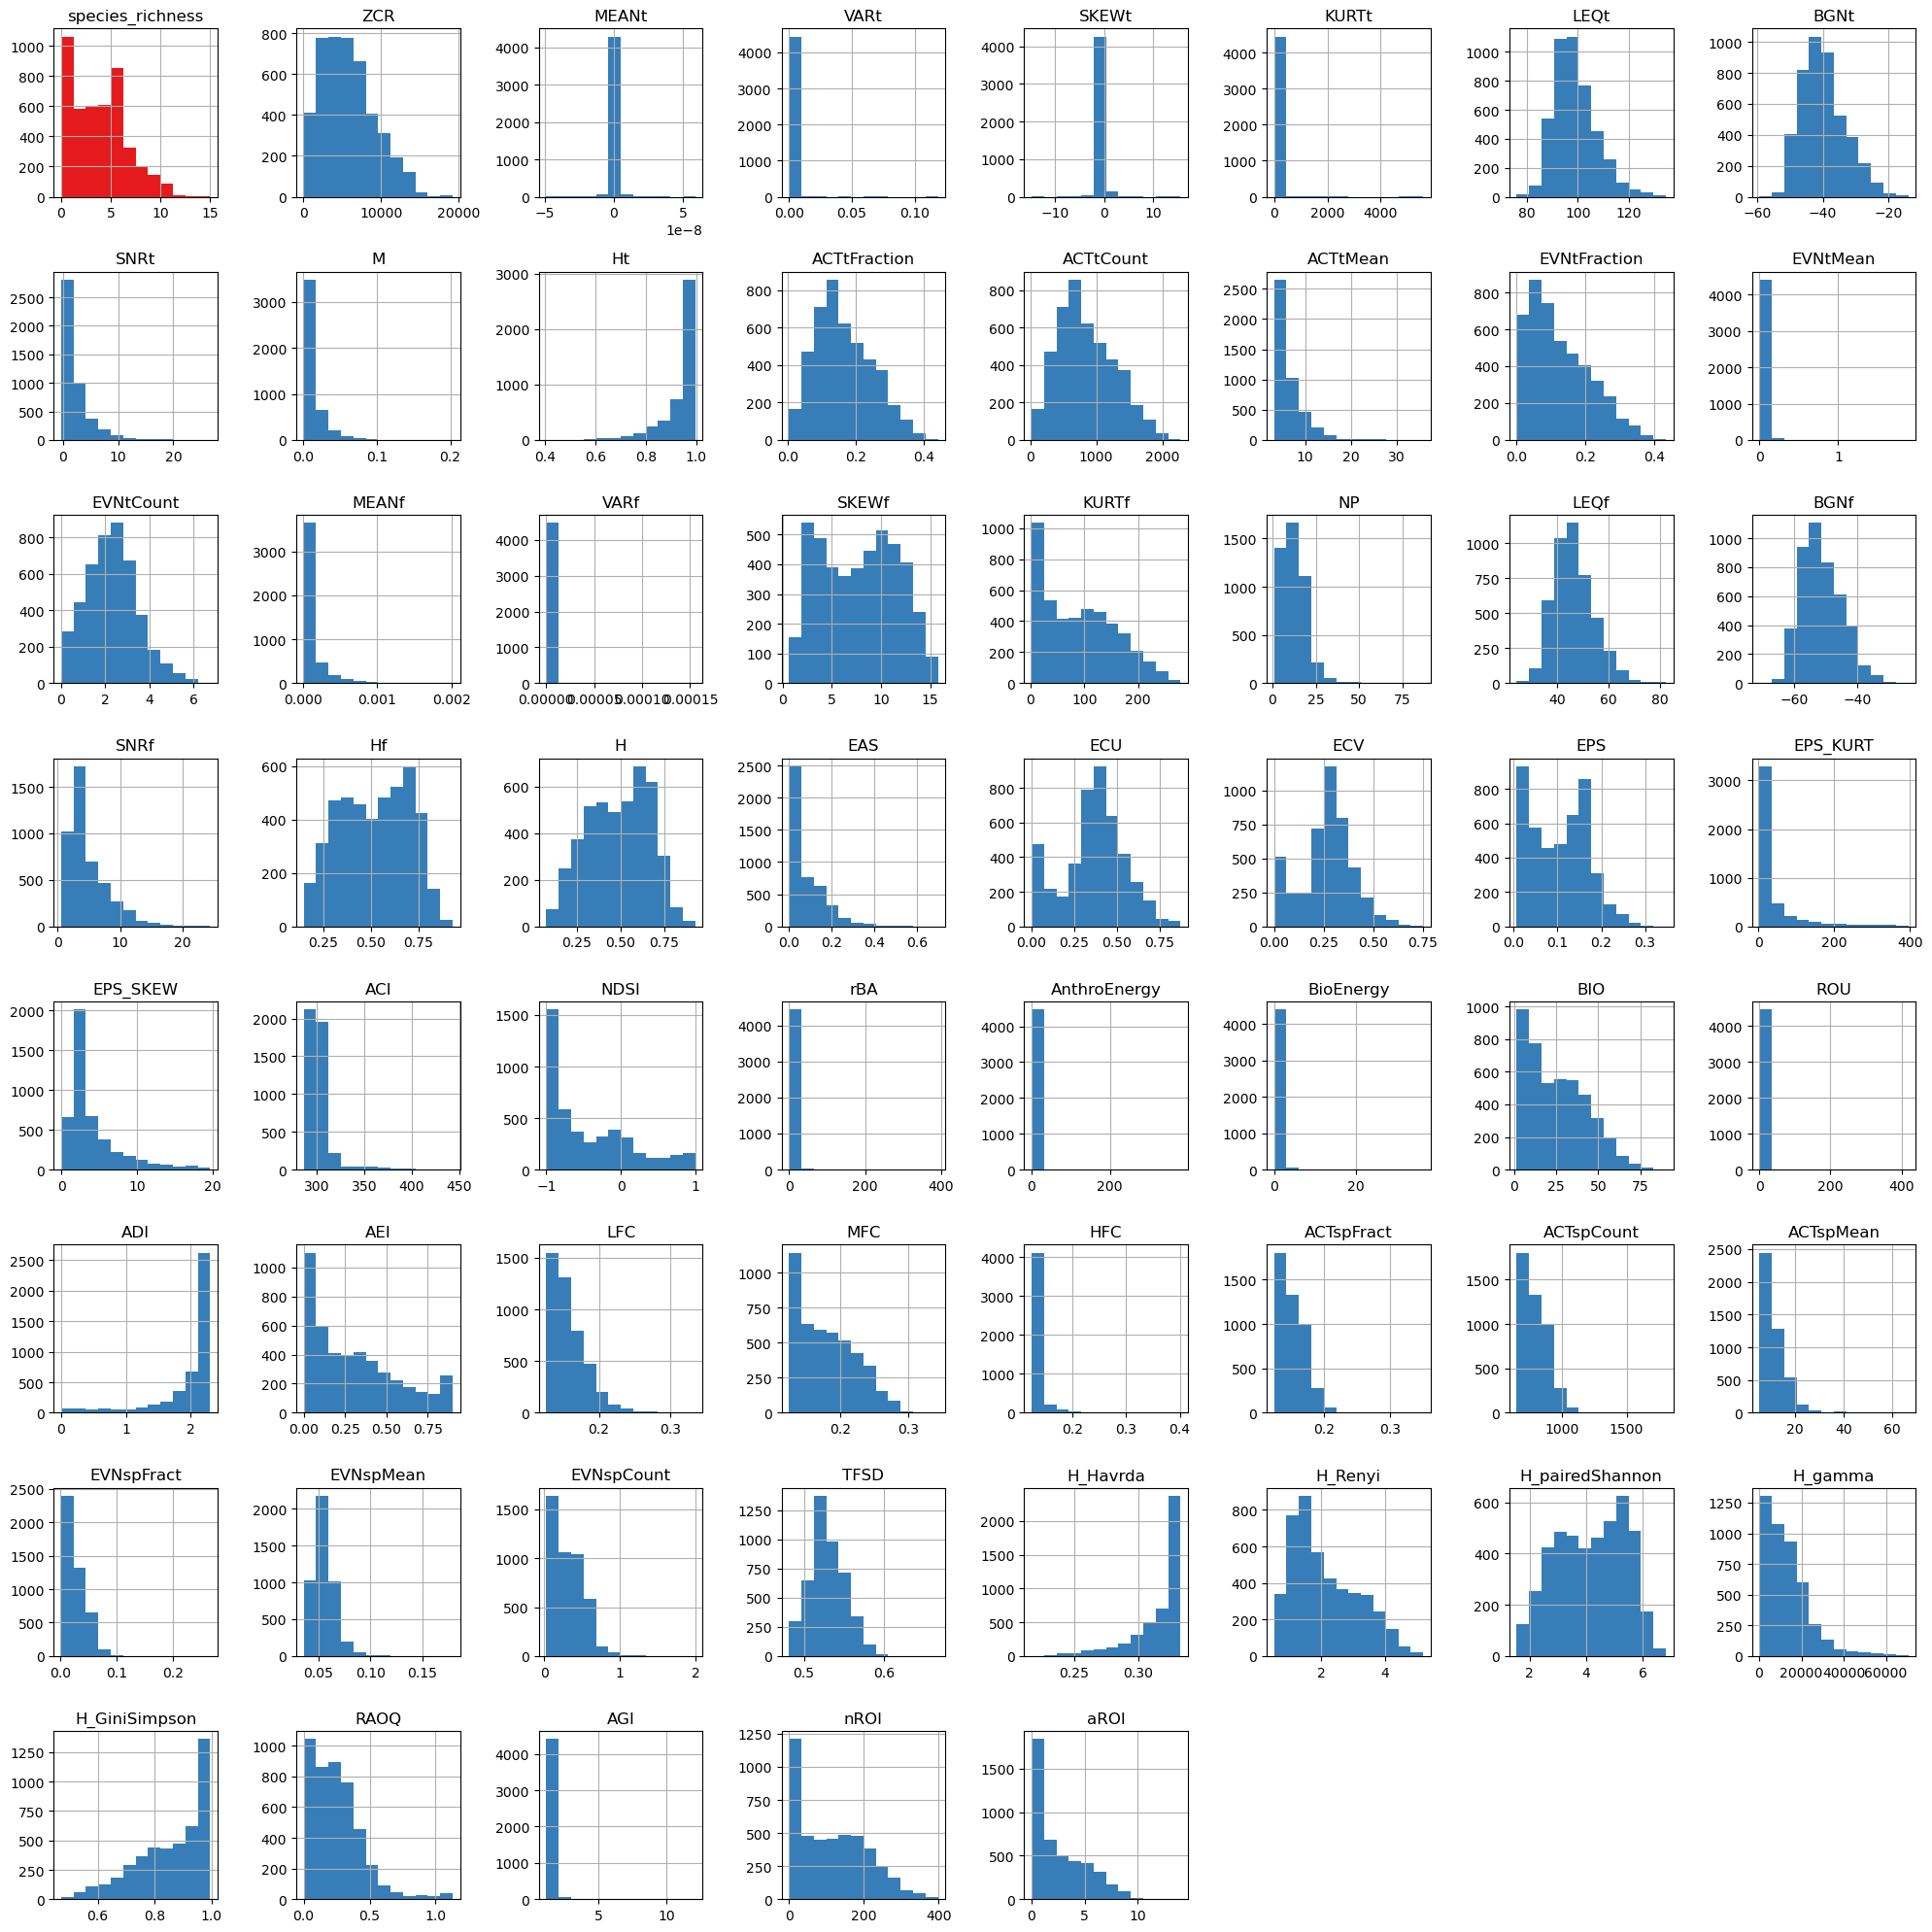

Statistics=0.950, p=0.000
The distribution of species_richness samples does not look Normal(reject H0)
Statistics=0.939, p=0.000
The distribution of nROI samples does not look Normal (reject H0)


In [5]:
# display the histogram of a ground truth parameter's distribution and an acoustic index's distribution
ax = df[[GT]+CONFIG['list_indices']].hist(bins=12, color=BLUE, figsize=(20, 20))

# change the cokor of the bins of the axis ax[0,0] to red
for patch in ax[0,0].patches:
    patch.set_facecolor(RED)

# Adjust layout
plt.tight_layout()
plt.show()

# test if the species_richness and nROI are normally distributed using scipy
from scipy.stats import shapiro

stat, p = shapiro(df['species_richness'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('The distribution of species_richness samples looks Normal (fail to reject H0)')
else:
    print('The distribution of species_richness samples does not look Normal(reject H0)')

stat, p = shapiro(df['nROI'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('The distribution of nROI samples looks Normal (fail to reject H0)')
else:
    print('The distribution of nROI samples does not look Normal (reject H0)')


### 3.3 Display the heatmap of the collected data

As all the audio were collected with different temporal sampling, it is interesting to have an overview of when they were acquired during the year and the time of the day. 

For this purpose, we can display a heatmap of the species richness, with the month on the vertical y-axis (first top row : Jan to Last row : Dec) and the time on the horizontal x-axis (from 00:00 to 23:45).

> We can observe that all the data were collected on a small range of day (usually one month duration) but on different time schedule, from 24h hours to dawn or dusk period of the day.

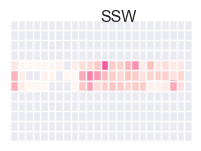

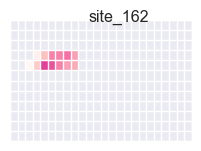

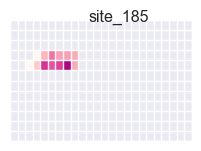

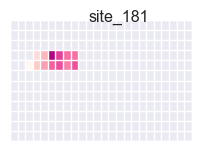

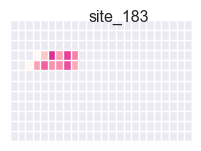

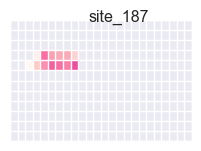

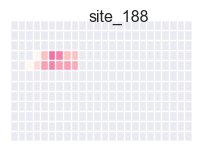

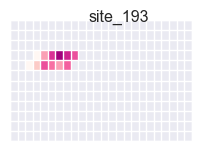

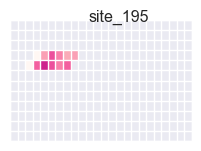

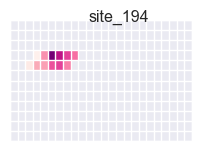

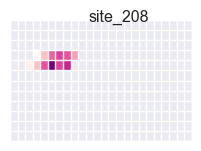

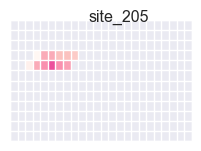

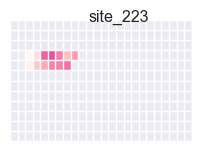

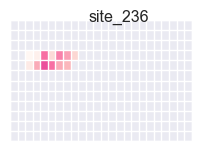

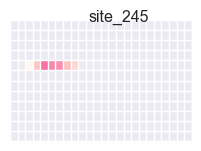

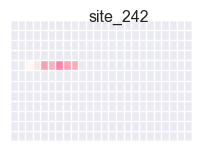

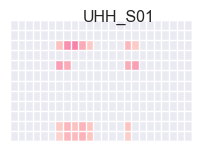

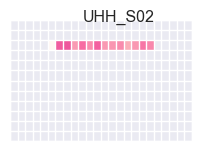

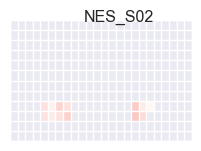

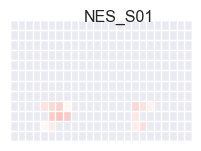

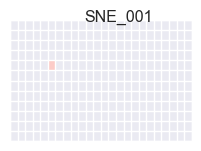

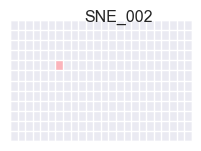

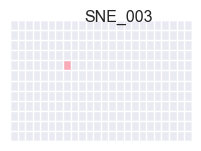

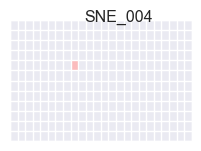

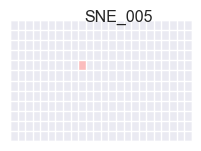

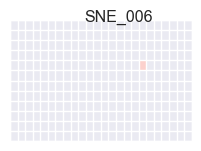

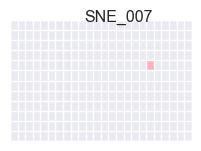

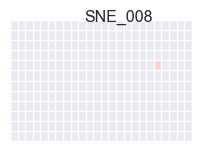

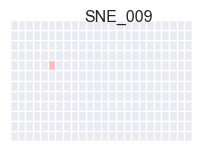

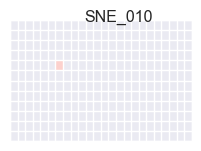

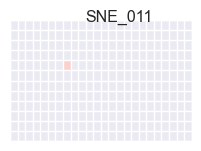

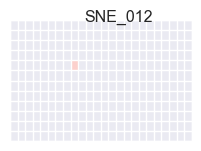

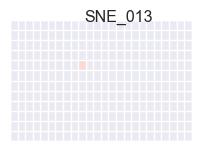

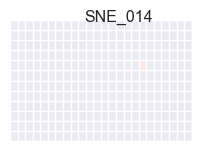

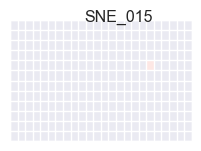

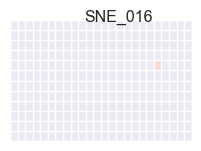

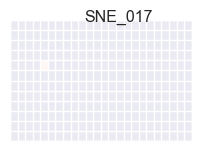

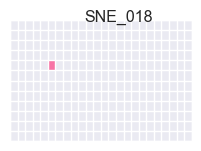

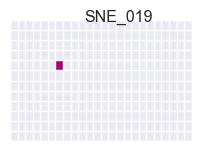

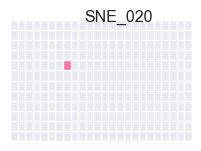

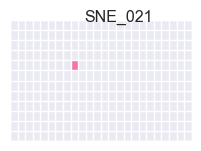

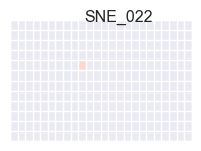

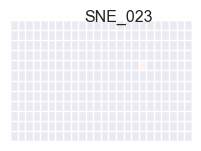

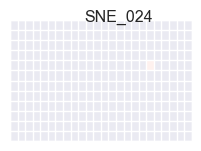

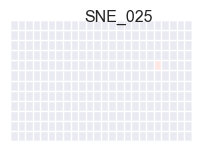

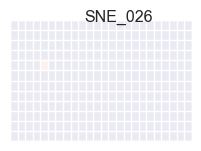

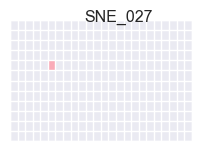

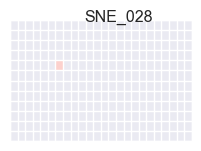

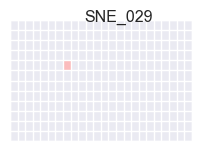

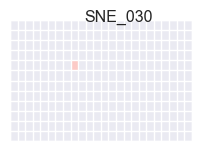

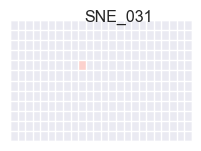

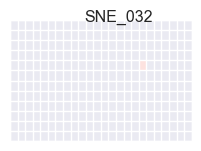

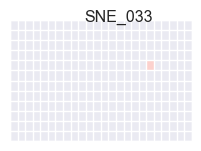

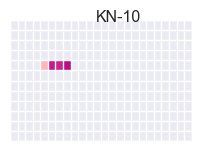

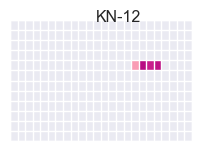

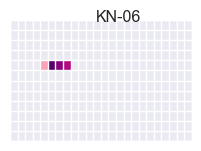

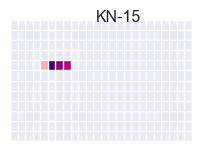

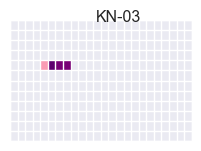

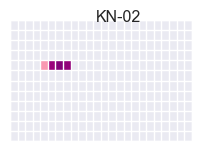

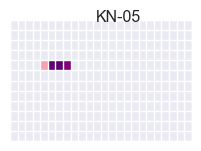

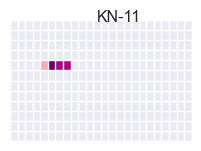

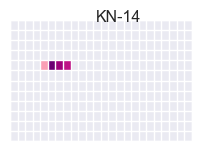

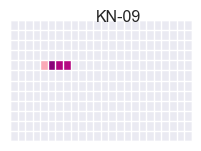

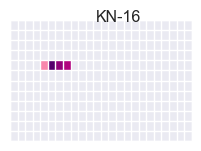

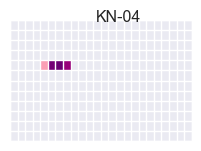

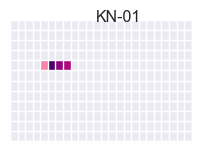

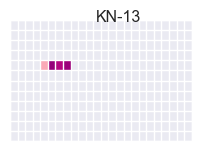

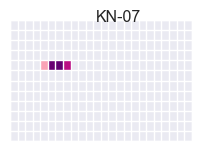

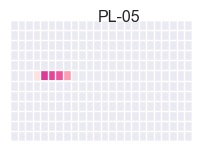

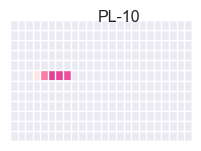

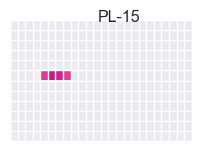

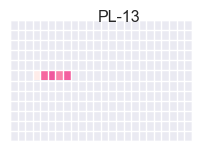

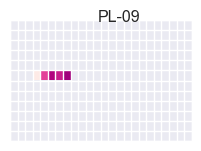

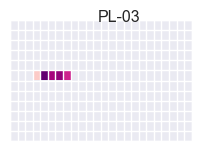

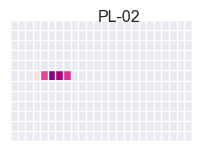

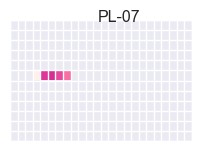

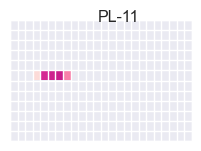

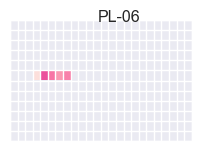

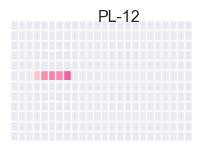

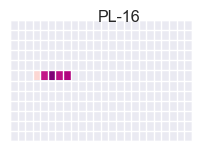

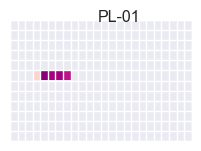

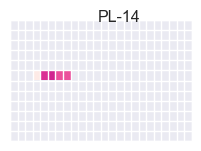

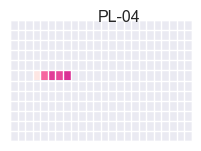

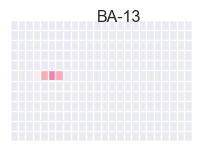

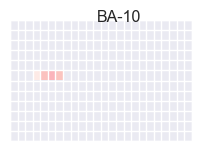

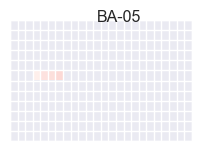

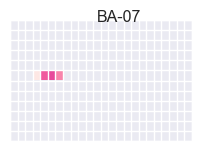

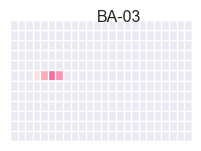

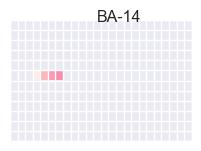

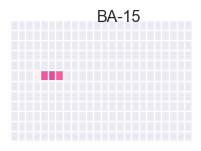

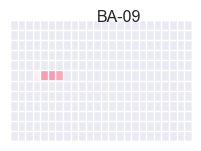

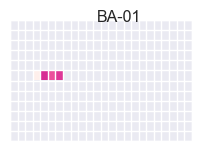

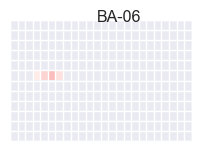

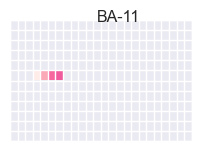

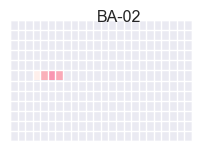

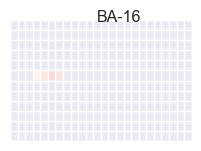

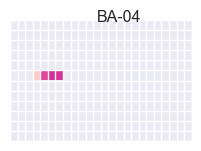

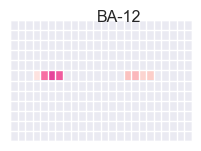

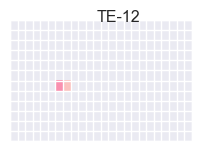

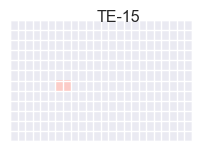

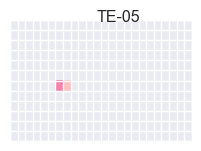

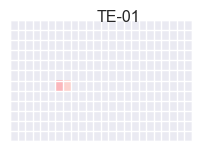

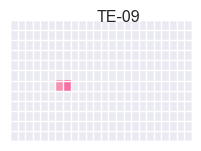

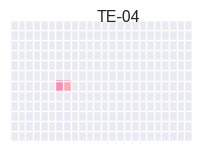

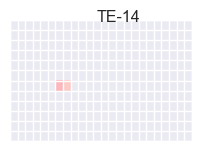

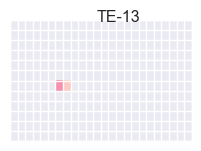

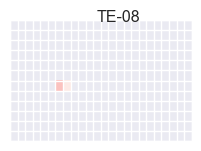

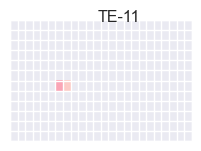

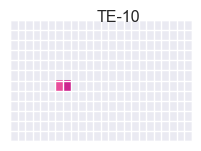

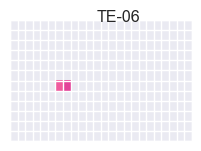

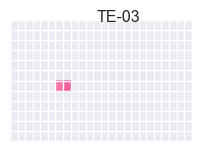

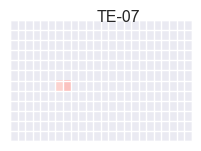

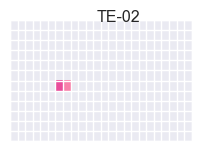

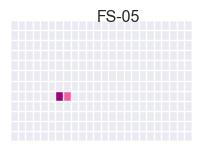

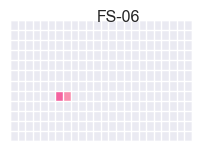

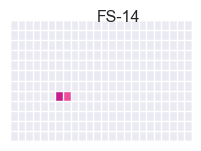

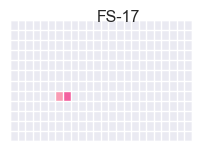

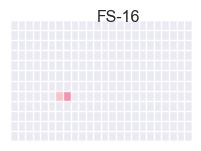

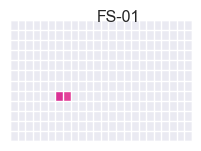

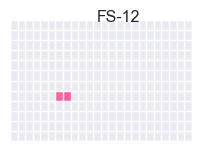

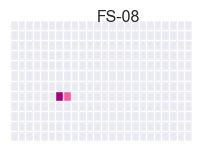

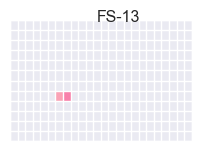

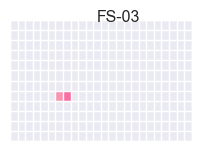

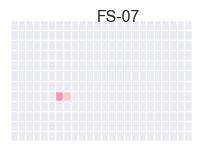

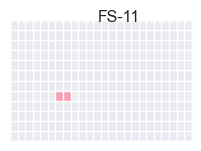

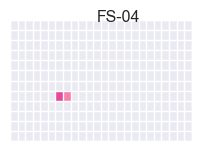

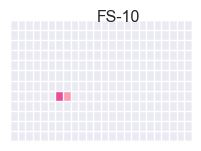

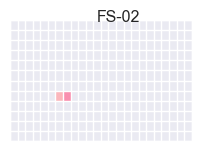

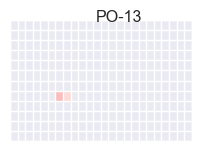

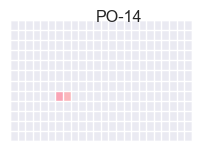

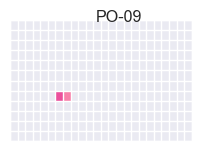

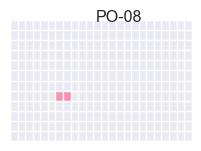

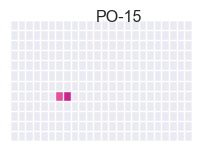

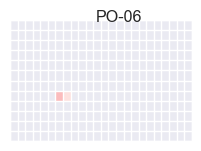

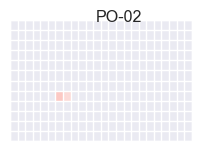

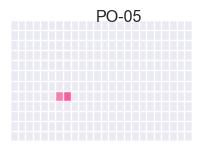

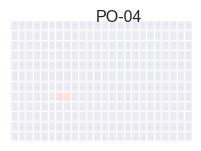

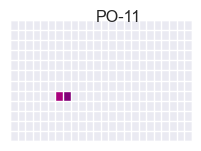

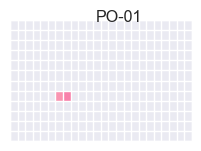

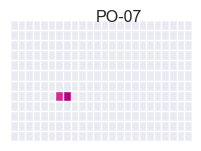

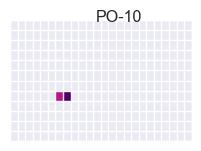

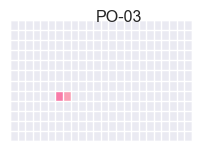

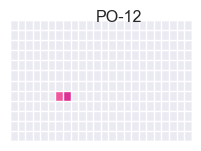

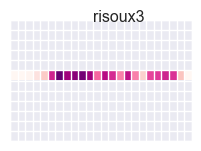

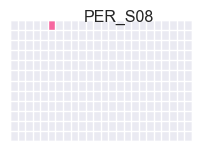

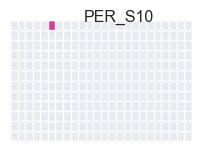

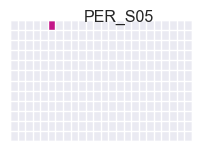

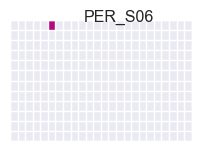

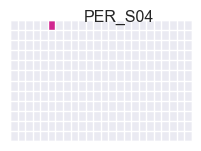

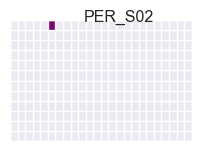

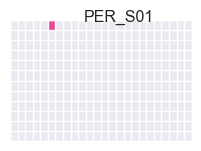

In [6]:
COLUMN = GT

for SITE in df['site'].unique() :

    df_per_site = df[df['site'] == SITE] 
    df_per_site = df_per_site.set_index(pd.to_datetime(df_per_site['date']))

    _,_, fig, ax = util.heatmap_by_date_and_time(df_per_site, 
                    disp_column = COLUMN, 
                    time_resolution='1H',
                    date_format = "%m",
                    full_display= True,
                    start_hour='00:00',
                    date_min_to_disp = 1,
                    date_max_to_disp = 12,
                    figsize=(3,2),
                    vmin = np.percentile(df[COLUMN], 5),
                    vmax = np.percentile(df[COLUMN], 95),
                    title = SITE,
                    now = False,
                    xlabel='',
                    ylabel='',
                    )
    
    # remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # remove the colorbar from the figure
    fig.delaxes(fig.axes[1])

    # Show the figure
    plt.show()


## 4. Analysis

### 4.1. Spearman correlation between indices and richness, habitat by habitat


************ Arable land **************
Number of points : 632 
Correlation coefficient with species_richness and indices: 
HFC         -0.34
ACI          0.32
ACTspMean    0.36
TFSD         0.41
aROI         0.46
EAS          0.46
EPS          0.52
EPS_KURT     0.53
EPS_SKEW     0.53
nROI         0.53
ECV          0.54
ECU          0.56
NP           0.60
Name: species_richness, dtype: float64
************ Forest - Subtropical-tropical moist lowland **************
Number of points : 309 
Correlation coefficient with species_richness and indices: 
AnthroEnergy   0.35
BioEnergy      0.36
BIO            0.36
ROU            0.37
VARf           0.37
MFC            0.37
LEQf           0.37
BGNf           0.38
VARt           0.38
LEQt           0.38
BGNt           0.39
M              0.39
MEANf          0.39
LFC            0.45
Name: species_richness, dtype: float64
************ Forest - Subtropical-tropical moist montane **************
Number of points : 355 
Correlation coefficient with spe

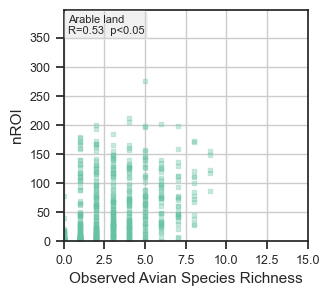

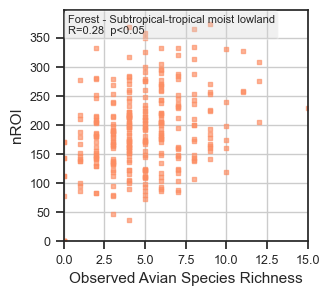

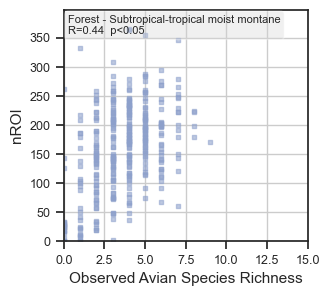

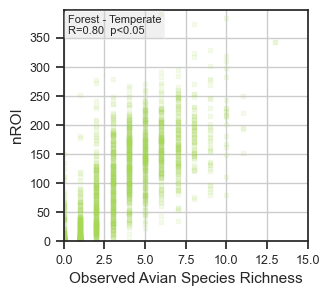

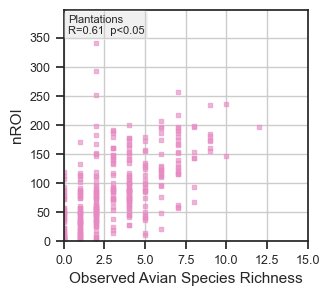

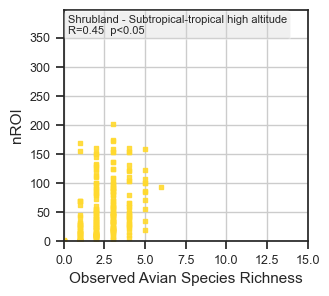

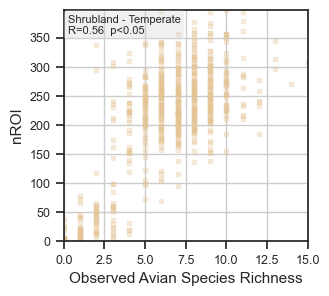

In [7]:
"""==============================================================================
        CORRELATION BETWEEN INDICES AND RICHNESS
        ----------------------------------------

        Summary of the steps:
        ---------------------
        - Select the index to display
        - Select the ground truth => species_richness
        - For each habitat
                - Compute the spearman correlation 
                - Display the scatter plot between the index and the ground truth
                - Save the figure

=============================================================================="""

# select the index to display
INDICE = 'nROI' 

# Set the label of the ground truth (x label)
if GT == 'species_richness' :
        GT_LABEL = 'Observed Avian Species Richness'
elif GT == 'species_abundance' :
        GT_LABEL = 'Species abundance'
else :
        GT_LABEL = GT

sns.set_theme(style="whitegrid")
sns.set_style("ticks")

# sort the column habitat to have the same automatic color assignation
df = df.sort_values(by='habitat')

for HABITAT in df['habitat'].unique() :

        # select the habitat
        subdf = df[df['habitat'] == HABITAT]

        print('************ ' + HABITAT +' **************')
        print("Number of points : {} ".format(len(subdf)))

        # Compute the correlation matrix
        corr_matrix = subdf.select_dtypes(include=['number']).corr(CORR_METHOD)
        best_corr_with_richness = corr_matrix[GT].loc[abs(corr_matrix[GT])>R_THRESHOLD]
        
        print("Correlation coefficient with {} and indices: \n{}".format(GT, best_corr_with_richness.sort_values()[:-1]))

        ############ p value #############
        if CORR_METHOD == 'spearman' :
                pval = spearmanr(subdf[INDICE], subdf[GT])[1]
        
        if pval >= 0.05 :
                pval_str = 'p=%.2f' % pval
        else:
                pval_str = 'p<0.05'

        ############ RICHNESS ###########
        fig, ax1 = plt.subplots(1, 1)
        # Set figure size
        fig.set_size_inches((3.25,3))
        fig.tight_layout()

        # Display the correlation graphic between the indice and the ground truth
        ##### SCATTER PLOT
        ax1.scatter(subdf[GT], subdf[INDICE],   alpha=min(1,200/len(subdf)), s=10,  marker = 's' , color=HABITAT_COLOR[HABITAT])
        ax1.grid()
        ax1.set_xlabel(GT_LABEL, fontdict={'size': 11})
        ax1.set_ylabel(INDICE, fontdict={'size': 11})
        ax1.set_xlim([df[GT].min(),df[GT].max()])
        ax1.set_ylim([df[INDICE].min(),df[INDICE].max()])
        ax1.annotate(
                "%s\nR=%.2f  %s" % (HABITAT, corr_matrix[GT][INDICE], pval_str), 
                xy=(0.018, 0.895), 
                xycoords='axes fraction', 
                fontsize = 8,
                bbox=dict(
                        facecolor='lightgrey', 
                        alpha = 0.33,
                        edgecolor='white', 
                        boxstyle='round')
                )
        # change font size of the x and y-axis tick labels
        ax1.tick_params(axis='x', labelsize=9)
        ax1.tick_params(axis='y', labelsize=9)

        if SAVE : fig.savefig(os.path.join(CONFIG['save_dir'], HABITAT+'_'+INDICE +'_vs_'+GT+'_onlybirds.png'), dpi = 300, bbox_inches = "tight")

Additional information about sites for each habitat :
- the total number of sites and files per habitat
- the site with the lowest number of files per habitat

In [8]:
# for each habitat find the number of sites and the number of files
for HABITAT in df['habitat'].unique() :
        subdf = df[df['habitat'] == HABITAT]
        n_sites = len(subdf['site'].unique())
        n_files = len(subdf)
        print(f'The habitat {HABITAT} contains {n_sites} sites and {n_files} files')

print('\n')

# for each habitat find the minimum of files that exist for a site
for HABITAT in df['habitat'].unique() :
        subdf = df[df['habitat'] == HABITAT]
        min_files_per_site = subdf.groupby('site').size().min()
        print(f'The habitat {HABITAT} contains a minimum of {min_files_per_site} files per site')
        # print the site with the minimum number of files
        site_min_files = subdf.groupby('site').size().idxmin()
        n_files_site_min = len(subdf[subdf['site'] == site_min_files])
        print(f'The site with the minimum number of files is {site_min_files} with {n_files_site_min} files')

The habitat Arable land contains 15 sites and 632 files
The habitat Forest - Subtropical-tropical moist lowland contains 22 sites and 309 files
The habitat Forest - Subtropical-tropical moist montane contains 16 sites and 355 files
The habitat Forest - Temperate contains 65 sites and 1949 files
The habitat Plantations contains 17 sites and 337 files
The habitat Shrubland - Subtropical-tropical high altitude contains 1 sites and 227 files
The habitat Shrubland - Temperate contains 15 sites and 675 files


The habitat Arable land contains a minimum of 42 files per site
The site with the minimum number of files is BA-01 with 42 files
The habitat Forest - Subtropical-tropical moist lowland contains a minimum of 12 files per site
The site with the minimum number of files is PER_S01 with 12 files
The habitat Forest - Subtropical-tropical moist montane contains a minimum of 15 files per site
The site with the minimum number of files is TE-01 with 15 files
The habitat Forest - Temperate contai

### 4.2. Spearman correlation between indices and richness, with all balanced habitats

The minimum number of samples is for the habitat Shrubland - Subtropical-tropical high altitude and the number is 227
Number of points : 1589 
Correlation coefficient with species_richness and indices: 
NDSI         0.31
rBA          0.31
LFC          0.34
EVNspMean    0.39
ACTspCount   0.46
ACTspFract   0.46
EAS          0.48
EPS          0.48
TFSD         0.48
BIO          0.49
ACTspMean    0.50
AGI          0.50
NP           0.51
EVNspCount   0.52
EVNspFract   0.54
MFC          0.56
aROI         0.65
nROI         0.67
Name: species_richness, dtype: float64


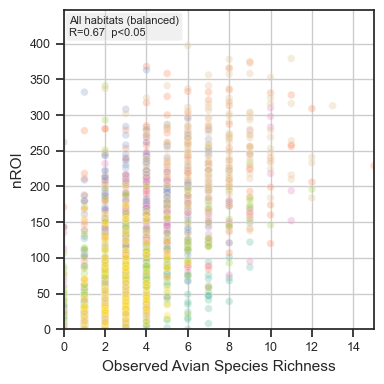

In [9]:
"""==============================================================================
        CORRELATION BETWEEN INDICES AND RICHNESS
        ----------------------------------------

        Summary of the steps:
        --------------------
        - Select the acoustic index (INDICE) => nROI
        - Select the ground truth (GT) => species_richness
        - Balance the dataset by habitat:
           - Find habitat with minimum sample count
           - Sample equal number of observations from each habitat
        - Save the balanced dataset to CSV
        - Compute correlation matrix using specified method (i.e. spearman)
        - Filter correlations above threshold (R_THRESHOLD)
        - Calculate p-value for statistical significance
        - Create the correlation plot between the selected index and ground truth:
           - Color points by habitat
           - Display correlation coefficient and p-value
        - Save the correlation plot figure

=============================================================================="""

INDICE = 'nROI' # nROI, aROI, NP, MFC LEQf, TFSD

# Set the label of the ground truth (x label)
if GT == 'species_richness' :
        GT_LABEL = 'Observed Avian Species Richness'
elif GT == 'species_abundance' :
        GT_LABEL = 'Species abundance'
else :
        GT_LABEL = GT

"""--------------------------------------------------------------
        Create a balanced dataset : same sampling by habitat.
--------------------------------------------------------------"""

# Group the DataFrame by 'habitat' and count the number of rows in each group
habitat_counts = df['habitat'].value_counts()

# Find the habitat with the minimum number of rows
min_habitat = habitat_counts.idxmin()
min_row_count = habitat_counts.min()

print("The minimum number of samples is for the habitat {} and the number is {}".format(min_habitat, min_row_count))

# Create an empty DataFrame to store the sampled data
sampled_df = pd.DataFrame(columns=df.columns)

# Iterate through each habitat and sample the minimum rows
for habitat, group in df.groupby('habitat'):
        sampled_rows = group.sample(n=min_row_count, random_state=CONFIG['seed'])  # Use a specific random_state for reproducibility
        sampled_df = pd.concat([sampled_df, sampled_rows])

# save the sampled dataframe
if SAVE :
        if CONFIG['remove_clipping_audio'] :
                sampled_df.to_csv(path_or_buf=os.path.join(CONFIG['save_dir'], 'data_species_balanced_sans_clip_onlybirds.csv'), sep=',', mode='w', header=True, index=True)
        else :
                sampled_df.to_csv(path_or_buf=os.path.join(CONFIG['save_dir'], 'data_species_balanced_onlybirds.csv'), sep=',', mode='w', header=True, index=True)

"""------------------------------
        Correlation.
--------------------------------"""

# set the R threshold to R_THRESHOLD
corr_matrix = sampled_df.select_dtypes(include=['number']).corr(CONFIG['correlation_method'])
best_corr = corr_matrix[GT].loc[abs(corr_matrix[GT])>R_THRESHOLD]

print("Number of points : {} ".format(len(sampled_df)))
print("Correlation coefficient with {} and indices: \n{}".format(GT, best_corr.sort_values()[:-1]))

# p value
if CORR_METHOD == 'spearman' :
        pval = spearmanr(sampled_df[INDICE], sampled_df[GT])[1]

if pval >= 0.05 :
        pval_str = 'p=%.2f' % pval
else:
        pval_str = 'p<0.05'

"""------------------------------
        Display.
--------------------------------"""
# Display the correlation graphic between the indice and the ground truth
fig, ax1 = plt.subplots(1, 1)

# SCATTER PLOT
sampled_df = sampled_df.sort_values(by='habitat')

# set the palette with the color of the habitats
sns.set_theme(style="whitegrid", palette=HABITAT_COLOR.values())
sns.set_style("ticks")

sns.scatterplot(data=sampled_df, x=GT, y=INDICE, hue='habitat', alpha=min(1,500/len(sampled_df)), s=30,  marker = 'o' , ax=ax1, legend=False)
ax1.grid()
ax1.set_xlim([sampled_df[GT].min(),sampled_df[GT].max()])
ax1.set_ylim([sampled_df[INDICE].min(),sampled_df[INDICE].max()+50])
ax1.set_xlabel(GT_LABEL, fontdict={'size': 11})
ax1.set_ylabel(INDICE, fontdict={'size': 11})
ax1.annotate(
        "All habitats (balanced)\nR=%.2f  %s" % (corr_matrix[GT][INDICE], pval_str), 
        xy=(0.018, 0.92), 
        xycoords='axes fraction', 
        fontsize = 8,
        bbox=dict(
                facecolor='lightgrey', 
                alpha = 0.33,
                edgecolor='white', 
                boxstyle='round')
        )
# change font size of the x and y-axis tick labels
ax1.tick_params(axis='x', labelsize=9)
ax1.tick_params(axis='y', labelsize=9)

# # Set figure size
fig.set_size_inches((4,4))
fig.tight_layout()

if SAVE : fig.savefig(os.path.join(CONFIG['save_dir'], 'figure_2_onlybirds.png'), dpi = 300, bbox_inches = "tight")

### 4.3. Bootstrap correlation of Spearman

In [10]:
"""==============================================================================
    Balanced option : Same sampling by habitat
    ------------------------------------------

    Summary of the steps:
    ---------------------
    - Group data by habitat and find minimum sample size
    - Create a balanced dataset with equal samples per habitat
    - Compute bootstrap correlations for each acoustic index
    - Calculate significance threshold using permutation test
    - Store statistics (r, CI, p-values) for balanced dataset
=============================================================================="""
if PROCESS :

    # load csv with balanced data
    if CONFIG['remove_clipping_audio'] :
        sampled_df = pd.read_csv(os.path.join(CONFIG['save_dir'], 'data_species_balanced_sans_clip_onlybirds.csv'), sep=',')
    else :
        sampled_df = pd.read_csv(os.path.join(CONFIG['save_dir'], 'data_species_balanced_onlybirds.csv'), sep=',')

    # list of stats as dictionnary (indice, r, ci, p_boot, p_perm)
    stat = []
    # list of null r
    combined_null_rs = []
    # Empty dataframe to store the stats
    df_stat = pd.DataFrame()

    for INDICE in tqdm(CONFIG['list_indices']) : 

        if sampled_df[INDICE].isna().any() == False :
            
            x = sampled_df[INDICE].astype('float')
            y = sampled_df[GT]

            real_r, p_boot, ci, _ = bootstrap_corr(x ,y , corr_method=CONFIG['correlation_method'], n_boot=CONFIG['n_bootstrap'], seed=CONFIG['seed'])

            _, p_perm, null_rs = permutation_corr(x ,y , corr_method=CONFIG['correlation_method'], n_boot=CONFIG['n_bootstrap'], seed=CONFIG['seed'])

            stat.append({'indice':INDICE, 'r': real_r, 'lower_bound_ci': ci[0], 'upper_bound_ci': ci[1], 'p_boot': p_boot, 'p_perm': p_perm})

            sorted_null_rs = np.sort(np.abs(null_rs))
            combined_null_rs.extend(null_rs)

    # Estimation of the r's threshold. Higher r than the threshold correlates significantly with the species richness
    combined_null_rs = np.asarray(combined_null_rs)
    combined_null_rs = combined_null_rs.flatten()

    # Adapted From Sarab Sethi's code (https://github.com/sarabsethi/sscape-avian-div-generalisability/blob/main/fig_richness_corrs_num_datasets.py)
    sorted_null_rs = np.sort(np.abs(combined_null_rs))
    sig_mult_hyp_corr = 1 - (0.05/CONFIG['n_bootstrap'])
    sig_ix = int(sig_mult_hyp_corr*len(sorted_null_rs))
    sig_level = sorted_null_rs[sig_ix]

    print('significant results for ({}\'s |r|>={})'.format(CONFIG['correlation_method'], sig_level))

    # Dataframe with the statistics
    df_stat_balanced = pd.DataFrame(stat)
    df_stat_balanced['habitat'] = 'all_balanced'
    df_stat_balanced['r_threshold'] = sig_level
    df_stat = pd.concat([df_stat, df_stat_balanced], ignore_index=True)

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [02:55<00:00,  2.92s/it]

significant results for (spearman's |r|>=0.10326883556606388)


In [ ]:
"""==============================================================================
    unbalanced option : whole dataset
    ------------------------------------------

    Summary of the steps:
    ---------------------
    - Use the entire dataset without balancing
    - Compute bootstrap correlations for each acoustic index
    - Calculate significance threshold using permutation test
    - Store statistics (r, CI, p-values) for balanced dataset
=============================================================================="""

if PROCESS :
    
    # list of stats as dictionnary (indice, r, ci, p_boot, p_perm)
    stat = []
    # list of null r
    combined_null_rs = []

    for INDICE in tqdm(CONFIG['list_indices'])  : 

        if df[INDICE].isna().any() == False :
            
            x = df[INDICE].astype('float')
            y = df[GT]

            real_r, p_boot, ci, _ = bootstrap_corr(x ,y , corr_method=CONFIG['correlation_method'], n_boot=CONFIG['n_bootstrap'], seed=CONFIG['seed'])

            _, p_perm, null_rs = permutation_corr(x ,y , corr_method=CONFIG['correlation_method'], n_boot=CONFIG['n_bootstrap'], seed=CONFIG['seed'])

            stat.append({'indice':INDICE, 'r': real_r, 'lower_bound_ci': ci[0], 'upper_bound_ci': ci[1], 'p_boot': p_boot, 'p_perm': p_perm})

            sorted_null_rs = np.sort(np.abs(null_rs))
            combined_null_rs.extend(null_rs)

    # Estimation of the r's threshold. Higher r than the threshold correlates significantly with the species richness
    combined_null_rs = np.asarray(combined_null_rs)
    combined_null_rs = combined_null_rs.flatten()

    sorted_null_rs = np.sort(np.abs(combined_null_rs))
    sig_mult_hyp_corr = 1 - (0.05/CONFIG['n_bootstrap'])
    sig_ix = int(sig_mult_hyp_corr*len(sorted_null_rs))
    sig_level = sorted_null_rs[sig_ix]

    print('significant results for ({}\'s |r|>={})'.format(CONFIG['correlation_method'], sig_level))

    # Dataframe with the statistics
    df_stat_unbalanced = pd.DataFrame(stat)
    df_stat_unbalanced['habitat'] = 'all_unbalanced'
    df_stat_unbalanced['r_threshold'] = sig_level
    df_stat = pd.concat([df_stat, df_stat_unbalanced], ignore_index=True)

  5%|▌         | 3/60 [00:22<06:57,  7.32s/it]

In [ ]:
"""==============================================================================
    For each habitat
    ------------------------------------------

    Summary of the steps:
    ---------------------
    - Use the entire dataset without balancing
    - Compute bootstrap correlations for each acoustic index
    - Calculate significance threshold using permutation test
    - Store statistics (r, CI, p-values) for balanced dataset
=============================================================================="""

if PROCESS :

    for HABITAT in tqdm(df['habitat'].unique()):

        # select the habitat
        subdf = df[df['habitat'] == HABITAT]

        # list of stats as dictionnary (indice, r, ci, p_boot, p_perm)
        stat = []
        # list of null r
        combined_null_rs = []

        for INDICE in tqdm(CONFIG['list_indices'])  : 

            if subdf[INDICE].isna().any() == False :
                
                x = subdf[INDICE].astype('float')
                y = subdf[GT]

                real_r, p_boot, ci, _ = bootstrap_corr(x, y, corr_method=CONFIG['correlation_method'], n_boot=CONFIG['n_bootstrap'], seed=CONFIG['seed'])

                _, p_perm, null_rs = permutation_corr(x, y, corr_method=CONFIG['correlation_method'], n_boot=CONFIG['n_bootstrap'], seed=CONFIG['seed'])

                stat.append({'indice':INDICE, 'r': real_r, 'lower_bound_ci': ci[0], 'upper_bound_ci': ci[1], 'p_boot': p_boot, 'p_perm': p_perm})

                sorted_null_rs = np.sort(np.abs(null_rs))
                combined_null_rs.extend(null_rs)

        ##### Estimation of the r's threshold. Higher r than the threshold correlates significantly with the species richness
        combined_null_rs = np.asarray(combined_null_rs)
        combined_null_rs = combined_null_rs.flatten()

        sorted_null_rs = np.sort(np.abs(combined_null_rs))
        sig_mult_hyp_corr = 1 - (0.05/CONFIG['n_bootstrap'])
        sig_ix = int(sig_mult_hyp_corr*len(sorted_null_rs))
        sig_level = sorted_null_rs[sig_ix]

        print('habitat : {}, significant results for ({}\'s |r|>={})'.format(HABITAT, CONFIG['correlation_method'], sig_level))

        # Dataframe with the statistics
        df_stat_per_habitat = pd.DataFrame(stat)
        df_stat_per_habitat['habitat'] = HABITAT
        df_stat_per_habitat['r_threshold'] = sig_level
        df_stat = pd.concat([df_stat, df_stat_per_habitat], ignore_index=True)


In [78]:
if PROCESS and SAVE : 
    if CONFIG['remove_clipping_audio'] :
        df_stat.to_csv(path_or_buf=os.path.join(CONFIG['save_dir'], GT+'_'+CONFIG['correlation_method']+"_r_sans_clip_onlybirds.csv"), sep=',', mode='w', header=True, index=False)
    else :
        df_stat.to_csv(path_or_buf=os.path.join(CONFIG['save_dir'], GT+'_'+CONFIG['correlation_method']+"_r_onlybirds.csv"), sep=',', mode='w', header=True, index=False)

elif PROCESS == False:
    if CONFIG['remove_clipping_audio'] :
        df_stat = pd.read_csv(os.path.join(CONFIG['save_dir'], GT+'_'+CONFIG['correlation_method']+"_r_sans_clip_onlybirds.csv"), sep=',', index_col=None)
    else :
        df_stat = pd.read_csv(os.path.join(CONFIG['save_dir'], GT+'_'+CONFIG['correlation_method']+"_r_onlybirds.csv"), sep=',', index_col=None)

display(df_stat)



,indice,r,lower_bound_ci,upper_bound_ci,p_boot,p_perm,habitat,r_threshold
0,ZCR,0.07,0.02,0.13,0.01,0.00,all_balanced,0.11
1,MEANt,0.02,-0.03,0.08,0.36,0.37,all_balanced,0.11
2,VARt,0.03,-0.01,0.09,0.20,0.20,all_balanced,0.11
3,SKEWt,-0.01,-0.06,0.05,0.67,0.69,all_balanced,0.11
4,KURTt,0.06,0.01,0.12,0.03,0.03,all_balanced,0.11
...,...,...,...,...,...,...,...,...
535,H_GiniSimpson,0.28,0.21,0.34,0.00,0.00,Shrubland - Temperate,0.16
536,RAOQ,0.21,0.14,0.27,0.00,0.00,Shrubland - Temperate,0.16
537,AGI,0.37,0.29,0.44,0.00,0.00,Shrubland - Temperate,0.16
538,nROI,0.56,0.49,0.62,0.00,0.00,Shrubland - Temperate,0.16


### 4.4. Heatmap with Spearman's coefficient R and the significance for each indice and habitat

['all_balanced', 'all_unbalanced', 'Forest - Temperate', 'Shrubland - Temperate', 'Forest - Subtropical-tropical moist lowland', 'Forest - Subtropical-tropical moist montane', 'Shrubland - Subtropical-tropical high altitude', 'Plantations', 'Arable land']


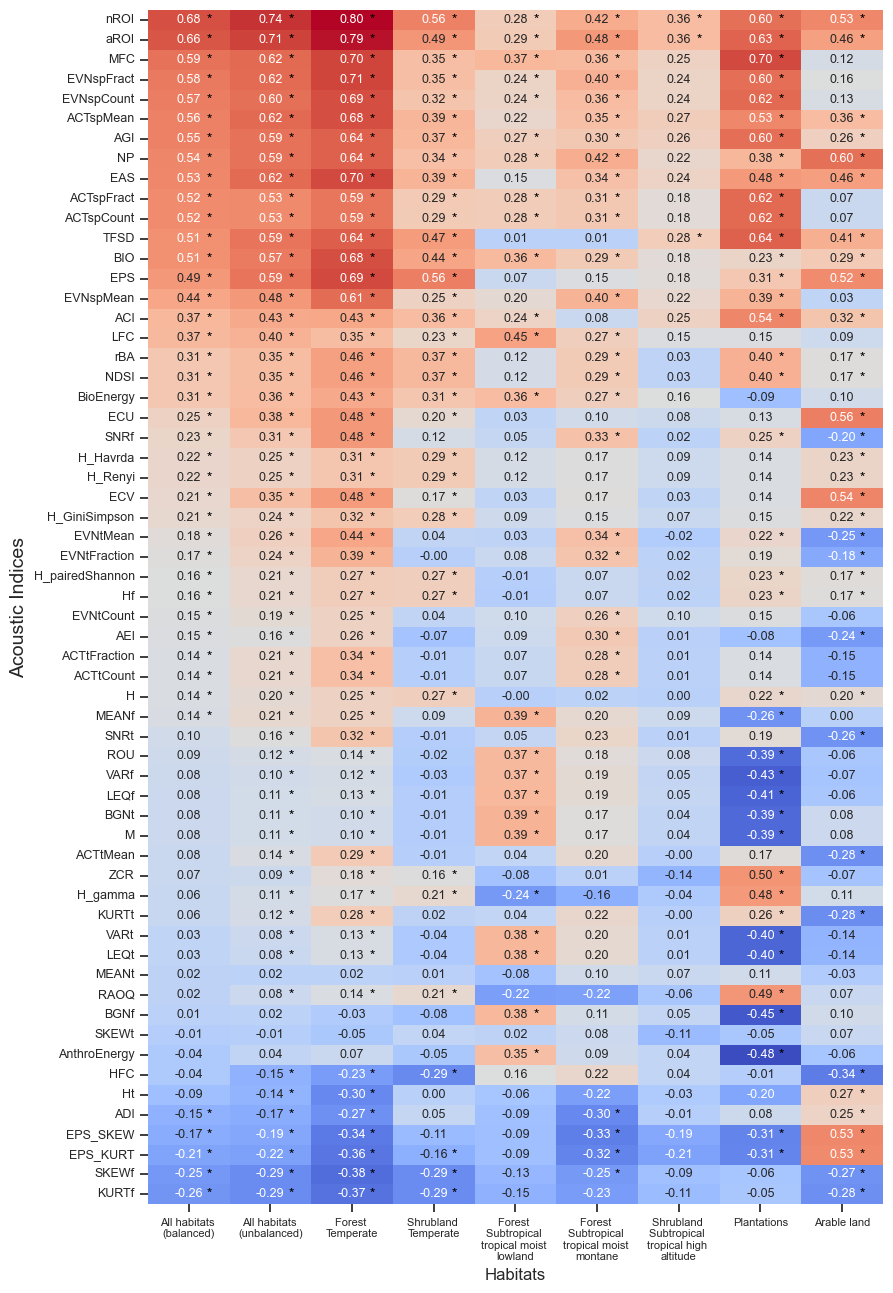

In [79]:
# create a table with the indice as rows and the habitats as columns and the r as values
df_stat_pivot = df_stat.pivot(index='indice', columns='habitat', values='r')

# sort the index to have the same order as the correlation coefficient
df_stat_pivot = df_stat_pivot.reindex(df_stat[df_stat['habitat']=='all_balanced'].sort_values(by='r', ascending=False)['indice'])

# Change the order of the columns to have first all_balanced and second	all_unbalanced
df_stat_pivot = df_stat_pivot[['all_balanced', 'all_unbalanced'] + 
                                ['Forest - Temperate', 
                                'Shrubland - Temperate', 
                                'Forest - Subtropical-tropical moist lowland',
                                'Forest - Subtropical-tropical moist montane', 
                                'Shrubland - Subtropical-tropical high altitude', 
                                'Plantations', 
                                'Arable land']]

"""---------------------------------------------------
    Display heatmap with the r values. 
----------------------------------------------------"""

# from the pivot table create a heatmap with the r values
# decrease font size of the annotation in the heatmap
# display all the labels in the y-axis
# add a star to the significant values
sns.set_theme(style="whitegrid", palette=PALETTE_NAME)
sns.set_style("ticks")
plt.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(figsize=(9, 13))
sns.heatmap(df_stat_pivot, annot=True, fmt=".2f", cmap='coolwarm', cbar=False, ax=ax)

# add a star to the significant values
for i in range(df_stat_pivot.shape[0]):
    for j in range(df_stat_pivot.shape[1]):
        if abs(df_stat_pivot.values[i,j]) >= df_stat[df_stat['habitat'] == df_stat_pivot.columns[j]]['r_threshold'].values[0] :
            ax.text(j+0.75, i+0.5, '*', ha='center', va='center', color='black', fontsize=10)

# Displaying the habitats in horizontal direction on several lines
print(list(df_stat_pivot))

habitats = [
    'All habitats \n(balanced)', 
    'All habitats \n(unbalanced)',
    'Forest \nTemperate',
    'Shrubland \nTemperate',
    'Forest \nSubtropical \ntropical moist \nlowland', 
    'Forest \nSubtropical \ntropical moist \nmontane', 
    'Shrubland \nSubtropical \ntropical high \naltitude', 
    'Plantations',
    'Arable land', 
]

# Customizing the axes labels
ax.set_xlabel('Habitats', fontsize=12)
ax.set_ylabel('Acoustic Indices', fontsize=14)
ax.set_xticklabels(habitats, rotation=0, ha="center", fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=9)

plt.tight_layout()
plt.show()

if SAVE : fig.savefig(os.path.join(CONFIG['save_dir'], 'figure_3_onlybirds.png'), dpi = 300, bbox_inches = "tight")

### 4.5. Find the best correlated indices

Best correlated indices must have a significant correlation (|r| > |r_threshold|) for each habitat
* find the indices with significant correlation for all habitat
* find the list of indices with significant correlation for each habitat
* find the list of indices with significantly moderate correlation (R_THRESHOLD => |0.3|) for each habitat

In [80]:
# filter df_stat in order to keep only the indices with |r |> |r_threshold|
df_stat_filtered = df_stat[abs(df_stat['r']) > abs(df_stat['r_threshold'])]

# get all habitats
habitats = df_stat_filtered['habitat'].unique()

# remove all_balanced and all_unbalanced from the list of habitats
habitats = habitats[habitats != 'all_balanced']
habitats = habitats[habitats != 'all_unbalanced']

# get all indices
indices = df_stat_filtered['indice'].unique()

# Filter the dataframe to keep only the indices that are present in all habitats
for HABITAT in habitats:
    print(HABITAT)
    df_stat_filtered_by_habitat = df_stat_filtered[df_stat_filtered['habitat'] == HABITAT]
    indices = np.intersect1d(indices, df_stat_filtered_by_habitat['indice'].unique())

# best indices
print('\n===> Indices with significant correlation for all tested habitats are:', str(indices))


Arable land
Forest - Subtropical-tropical moist lowland
Forest - Subtropical-tropical moist montane
Forest - Temperate
Plantations
Shrubland - Subtropical-tropical high altitude
Shrubland - Temperate

===> Indices with significant correlation for all tested habitats are: ['aROI' 'nROI']


In [81]:
# Loop through habitats and print the indices that correlate with richness
for HABITAT in habitats:
    print(f'\n---------- {HABITAT}')
    list_indices = []
    for indice in CONFIG['list_indices']:
        sub_df_stat = df_stat[df_stat['indice']==indice]
        r_threshold = sub_df_stat[sub_df_stat['habitat'] == HABITAT]['r_threshold'].values[0]
        r           = sub_df_stat[sub_df_stat['habitat'] == HABITAT]['r'].values[0]
        if abs(r) >= r_threshold :
            list_indices+= [indice]
    # print the number of indices
    print(f'The number of indices that correlates with richness is {len(list_indices)}')
    print(list_indices)


---------- Arable land
The number of indices that correlates with richness is 34
['KURTt', 'SNRt', 'Ht', 'ACTtMean', 'EVNtFraction', 'EVNtMean', 'SKEWf', 'KURTf', 'NP', 'SNRf', 'Hf', 'H', 'EAS', 'ECU', 'ECV', 'EPS', 'EPS_KURT', 'EPS_SKEW', 'ACI', 'NDSI', 'rBA', 'BIO', 'ADI', 'AEI', 'HFC', 'ACTspMean', 'TFSD', 'H_Havrda', 'H_Renyi', 'H_pairedShannon', 'H_GiniSimpson', 'AGI', 'nROI', 'aROI']

---------- Forest - Subtropical-tropical moist lowland
The number of indices that correlates with richness is 24
['VARt', 'LEQt', 'BGNt', 'M', 'MEANf', 'VARf', 'NP', 'LEQf', 'BGNf', 'ACI', 'AnthroEnergy', 'BioEnergy', 'BIO', 'ROU', 'LFC', 'MFC', 'ACTspFract', 'ACTspCount', 'EVNspFract', 'EVNspCount', 'H_gamma', 'AGI', 'nROI', 'aROI']

---------- Forest - Subtropical-tropical moist montane
The number of indices that correlates with richness is 28
['ACTtFraction', 'ACTtCount', 'EVNtFraction', 'EVNtMean', 'EVNtCount', 'SKEWf', 'NP', 'SNRf', 'EAS', 'EPS_KURT', 'EPS_SKEW', 'NDSI', 'rBA', 'BioEnergy', 'B

In [82]:
# Loop through habitats and print the indices that have a correlation coefficient > R_THRESHOLD
for HABITAT in habitats:
    print(f'\n---------- {HABITAT}')
    list_indices = []
    for indice in CONFIG['list_indices']:
        sub_df_stat = df_stat[df_stat['indice']==indice]
        r_threshold = R_THRESHOLD
        r           = sub_df_stat[sub_df_stat['habitat'] == HABITAT]['r'].values[0]
        if abs(r) >= r_threshold :
            list_indices+= [indice]
    # print the number of indices
    print(f'The number of indices that correlates with richness with |R|>{R_THRESHOLD} is {len(list_indices)}')
    print(list_indices)


---------- Arable land
The number of indices that correlates with richness with |R|>0.3 is 13
['NP', 'EAS', 'ECU', 'ECV', 'EPS', 'EPS_KURT', 'EPS_SKEW', 'ACI', 'HFC', 'ACTspMean', 'TFSD', 'nROI', 'aROI']

---------- Forest - Subtropical-tropical moist lowland
The number of indices that correlates with richness with |R|>0.3 is 14
['VARt', 'LEQt', 'BGNt', 'M', 'MEANf', 'VARf', 'LEQf', 'BGNf', 'AnthroEnergy', 'BioEnergy', 'BIO', 'ROU', 'LFC', 'MFC']

---------- Forest - Subtropical-tropical moist montane
The number of indices that correlates with richness with |R|>0.3 is 19
['EVNtFraction', 'EVNtMean', 'NP', 'SNRf', 'EAS', 'EPS_KURT', 'EPS_SKEW', 'ADI', 'AEI', 'MFC', 'ACTspFract', 'ACTspCount', 'ACTspMean', 'EVNspFract', 'EVNspMean', 'EVNspCount', 'AGI', 'nROI', 'aROI']

---------- Forest - Temperate
The number of indices that correlates with richness with |R|>0.3 is 35
['SNRt', 'ACTtFraction', 'ACTtCount', 'EVNtFraction', 'EVNtMean', 'SKEWf', 'KURTf', 'NP', 'SNRf', 'EAS', 'ECU', 'ECV', 

### 4.6. Display the Spearman's coefficient R issued from bootstrap and the significant R threshold

* First for all habitat with balanced and unbalanced condition
* Then for each habitat

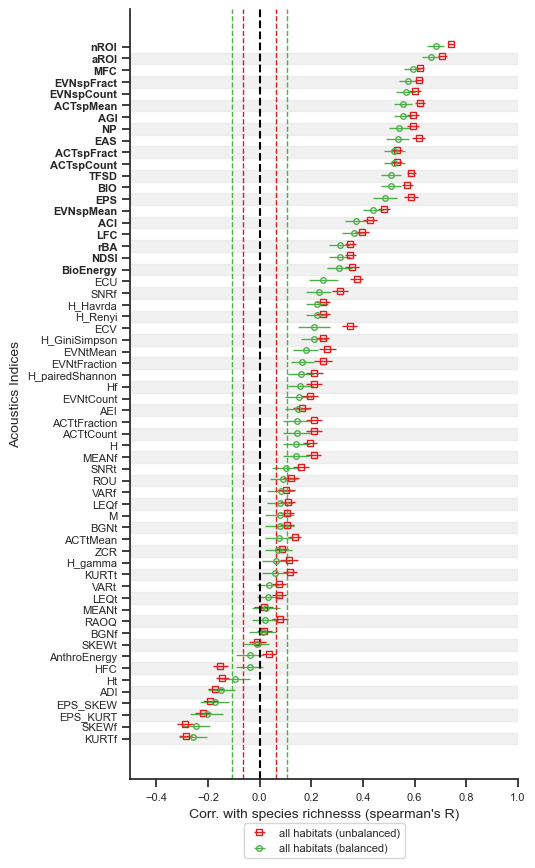

Number of indices with |R| > r_threshold_all_unbalanced for all habitats (unbalanced) : 56
Number of indices with |R| > r_threshold_all_balanced for all habitats (balanced) : 41
Number of indices with |R| > 0.3 for all habitats (balanced) : 20
Indices with |R| > 0.3 for all habitats (balanced) : ['NP', 'EAS', 'EPS', 'ACI', 'NDSI', 'rBA', 'BioEnergy', 'BIO', 'LFC', 'MFC', 'ACTspFract', 'ACTspCount', 'ACTspMean', 'EVNspFract', 'EVNspMean', 'EVNspCount', 'TFSD', 'AGI', 'nROI', 'aROI']
Indices with |R| < 0.3 for all habitats (balanced) : ['ZCR', 'MEANt', 'VARt', 'SKEWt', 'KURTt', 'LEQt', 'BGNt', 'SNRt', 'M', 'Ht', 'ACTtFraction', 'ACTtCount', 'ACTtMean', 'EVNtFraction', 'EVNtMean', 'EVNtCount', 'MEANf', 'VARf', 'SKEWf', 'KURTf', 'LEQf', 'BGNf', 'SNRf', 'Hf', 'H', 'ECU', 'ECV', 'EPS_KURT', 'EPS_SKEW', 'AnthroEnergy', 'ROU', 'ADI', 'AEI', 'HFC', 'H_Havrda', 'H_Renyi', 'H_pairedShannon', 'H_gamma', 'H_GiniSimpson', 'RAOQ']


In [83]:
"""===============================================================================
    Display errorbar plot with the r values for balanced and unbalanced dataset
    ---------------------------------------------------------------------------

    Summary of the steps:
    ---------------------
    - Sort indices by Spearman's r for 'all_balanced' and create an indice→position mapping in order
    to display the indices from lowest to highest r.
    - Split df_stat into 'all_balanced' and 'all_unbalanced'; compute error bars as r - lower_bound_ci.
    - Plot error bars for both datasets with distinct markers/colors and set axis labels/styles.
    - Draw vertical lines at 0 and at ±r_threshold for balanced and unbalanced datasets.
    - Set y-ticks/labels; bold labels where |r| > R_THRESHOLD (=0.3) for the balanced dataset.
    - Shade alternating rows, set x-limits, add legend, and show the figure.
    - Print counts of indices with |r| above dataset-specific thresholds and above R_THRESHOLD,
    plus lists of indices above/below R_THRESHOLD for the balanced dataset.

================================================================================"""
    

# sort by r obtained with balanced dataset by habitats
sort_indices = df_stat[df_stat['habitat']=='all_balanced'].sort_values(by='r', ascending=True)['indice']

# Create an empty dictionary to store the mapping
indice_mapping = {}

# Iterate over the unique values of 'indice' and assign corresponding numbers
i = 0
for unique_indice in sort_indices:
    indice_mapping[unique_indice] = i
    i += 1

# Add the dictionary to the DataFrame
df_stat['indice_number'] = df_stat['indice'].map(indice_mapping)

# Generating labels and index
label = sort_indices
y = np.arange(len(label))

# select the indices with r > r_threshold for each habitat, dataset
df_all_balanced = df_stat[(df_stat['habitat']=='all_balanced')]
df_all_unbalanced = df_stat[(df_stat['habitat']=='all_unbalanced')]

# Apply the function to the 'list_column' and store the result in a new column
err_balanced = df_all_balanced['r'] - df_all_balanced['lower_bound_ci']
err_unbalanced =  df_all_unbalanced['r'] - df_all_unbalanced['lower_bound_ci']

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(5,10))
ax.errorbar(x = df_all_unbalanced['r'], 
            y = df_all_unbalanced['indice_number'] + 0.2, 
            xerr=err_unbalanced, 
            label = 'all habitats (unbalanced)',
            marker='s', markersize = 4, markerfacecolor='none',
            linestyle="none", linewidth=1, color=RED, ecolor=RED)
ax.errorbar(x = df_all_balanced['r'], 
            y = df_all_balanced['indice_number'] + 0.1, 
            xerr=err_balanced, 
            label = 'all habitats (balanced)',
            marker='o', markersize = 4, markerfacecolor='none',
            linestyle="none", linewidth=1, color=GREEN, ecolor=GREEN)

ax.set_xlabel('Corr. with species richnesss ({}\'s R)'.format(CONFIG['correlation_method']), fontsize=10)
ax.set_ylabel('Acoustics Indices', fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', labelsize=8)

# Draw a vertical line at 0
ax.axvline(x=0, color='black', linestyle='dashed')
ax.axvline(x=df_stat[df_stat['habitat']=='all_unbalanced']['r_threshold'].unique(), color=RED, linestyle='dashed',linewidth=1)
ax.axvline(x=df_stat[df_stat['habitat']=='all_balanced']['r_threshold'].unique(), color=GREEN, linestyle='dashed',linewidth=1)
ax.axvline(x=-df_stat[df_stat['habitat']=='all_unbalanced']['r_threshold'].unique(), color=RED, linestyle='dashed',linewidth=1)
ax.axvline(x=-df_stat[df_stat['habitat']=='all_balanced']['r_threshold'].unique(), color=GREEN, linestyle='dashed',linewidth=1)

# Reset y-ticks
ax.set_yticks(y)
# Setting y-axis tick labels
ax.set_yticklabels(label)

# Get axis labels
yticklabels = plt.gca().get_yticklabels()

# Loop through labels and set font weight depending on the R value
for label in yticklabels:
    sub_df_stat = df_stat[df_stat['indice']==label.get_text()]

    # test if r is higher than r_threshold for habitat = 'all_balanced' and habitat = 'all_unbalanced'
    r_threshold_all_balanced = sub_df_stat[sub_df_stat['habitat'] == 'all_balanced']['r_threshold'].values[0]
    r_all_balanced = sub_df_stat[sub_df_stat['habitat'] == 'all_balanced']['r'].values[0]
    r_threshold_all_unbalanced = sub_df_stat[sub_df_stat['habitat'] == 'all_unbalanced']['r_threshold'].values[0]
    r_all_unbalanced = sub_df_stat[sub_df_stat['habitat'] == 'all_unbalanced']['r'].values[0]
    
    if ((abs(r_all_balanced)) > (abs(R_THRESHOLD)))  :
        label.set_fontweight('bold')

# Get the tick positions
y_ticks = ax.get_yticks()
# Get the interval
y_delta = y_ticks[1] - y_ticks[0]
# Change background color every two ticks
for i in range(0, len(y_ticks), 2):
    ax.axhspan(y_ticks[i]- y_delta/ 2, y_ticks[i] + y_delta/ 2, color='lightgrey', alpha=0.3)

# Set the x-axis limits
ax.set_xlim(-0.5, 1)
# Create the legend and place it at the bottom of the figure
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fontsize=8)

plt.show()

# Count the number of indices with r > r_threshold for habitats = 'all_balanced' and habitats = 'all_unbalanced'
print('Number of indices with |R| > r_threshold_all_unbalanced for all habitats (unbalanced) :', len(df_all_unbalanced[abs(df_all_unbalanced['r']) > r_threshold_all_unbalanced]))
print('Number of indices with |R| > r_threshold_all_balanced for all habitats (balanced) :', len(df_all_balanced[abs(df_all_balanced['r']) > r_threshold_all_balanced]))
# Count the number of indices with r > r_threshold for habitats = 'all_balanced' and habitats = 'all_unbalanced'
print('Number of indices with |R| > 0.3 for all habitats (balanced) :', len(df_all_balanced[abs(df_all_balanced['r']) > R_THRESHOLD]))
# display the list of indices with r > r_threshold for all habitats (balanced)
print('Indices with |R| > 0.3 for all habitats (balanced) :', list(df_all_balanced[abs(df_all_balanced['r']) > R_THRESHOLD]['indice']))
# display the list of indices with r > r_threshold for all habitats (balanced)
print('Indices with |R| < 0.3 for all habitats (balanced) :', list(df_all_balanced[abs(df_all_balanced['r']) < R_THRESHOLD]['indice']))

### 4.7 Correlation between average values per site

In [84]:
"""===============================================================================
    Group data and compute the correlation the indice and the ground truth
    ----------------------------------------------------------------------

    Summary of the steps:
    ---------------------
    - Group data by 'site' and calculate mean for numeric columns
    - Filter out sites with less than 3 samples
    - Compute correlation matrix using specified method (i.e. spearman)
    - Filter correlations above threshold (R_THRESHOLD=0.3)
    - Map habitat information to grouped data for futher use
    - Save the grouped data to CSV

================================================================================"""

# Use the groupby method to group by the 'site' column
grouped = df.groupby('site')

# Filter numeric columns
numeric_columns = df.select_dtypes(include=[int, float])

# Group by 'site' and calculate the mean for each numeric column
df_count= grouped[numeric_columns.columns].count()
df_mean = grouped[numeric_columns.columns].mean()
df_std  = grouped[numeric_columns.columns].std()

# add a count column to keep the nummber of 1min audio files by site
df_mean['count'] = df_count.iloc[:,0]

""" -----------------------------------------------------
    remove sites with count less than 3 sampling effort
-------------------------------------------------------"""
print(f"The number of sites before filtering is {df_mean.shape[0]}")
df_mean = df_mean[df_mean['count']>=3]
print(f"The number of sites after filtering is {df_mean.shape[0]}")

corr_matrix = df_mean.select_dtypes(include=['number']).corr(CONFIG['correlation_method'])
best_corr = corr_matrix[GT].loc[abs(corr_matrix[GT])>R_THRESHOLD]

print("Correlation coefficient with {} and indices: \n{}".format(GT, best_corr.sort_values()[:-1]))

# Create a dictionary from 'df' with 'site' as keys and 'habitat' as values
site_to_habitat = df.set_index('site')['habitat'].to_dict()
# Map the 'habitat' values to df_mean based on 'site'
df_mean['habitat'] = (df_mean.reset_index()['site'].map(site_to_habitat)).to_list()
# Reset the index 'site'
df_mean.reset_index(inplace=True)

if SAVE : 
    if CONFIG['remove_clipping_audio'] :
        df_mean.to_csv(path_or_buf=os.path.join(CONFIG['save_dir'], GT+"_by_site_sans_clip_onlybirds.csv"), sep=',', mode='w', header=True, index=False)
    else :
        df_mean.to_csv(path_or_buf=os.path.join(CONFIG['save_dir'], GT+"_by_site_onlybirds.csv"), sep=',', mode='w', header=True, index=False)

The number of sites before filtering is 151
The number of sites after filtering is 151
Correlation coefficient with species_richness and indices: 
EPS_KURT     -0.36
EPS_SKEW     -0.33
EVNtCount     0.30
M             0.30
BGNt          0.31
MEANf         0.31
LON           0.34
BioEnergy     0.36
NDSI          0.40
count         0.40
ACI           0.42
rBA           0.43
ECV           0.45
ECU           0.52
EPS           0.60
TFSD          0.60
EVNspMean     0.61
LFC           0.61
EAS           0.64
AGI           0.64
NP            0.65
BIO           0.65
ACTspMean     0.65
ACTspCount    0.75
ACTspFract    0.75
MFC           0.75
EVNspFract    0.75
aROI          0.76
EVNspCount    0.78
nROI          0.80
Name: species_richness, dtype: float64


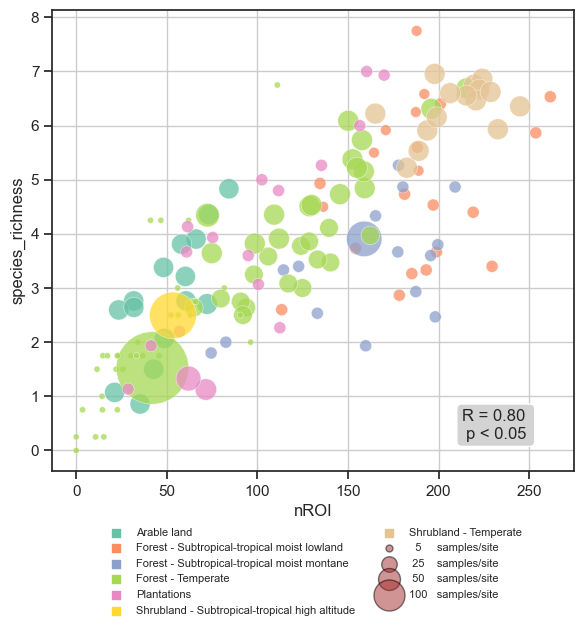

In [85]:
"""===============================================================================
        Display correlation  between the indice and the ground truth
        ------------------------------------------------------------

        Summary of the steps:
        ---------------------
        - Using the grouped data by site
        - Select the acoustic index (INDICE) => nROI
        - Select the ground truth (GT) => species_richness
        - Display the correlation plot between the selected index and ground truth:
                - Marker size by number of samples per site
                - Color points by habitat
                - Display correlation coefficient and p-value
        - Save the correlation plot figure

==============================================================================="""

INDICE_TO_DISPLAY = 'nROI' # nROI, aROI, NP, MFC BI

# Display the correlation graphic between the indice and the ground truth
fig, ax1 = plt.subplots(1, 1)

# sort the column habitat to have the same automatic color assignation
df_mean = df_mean.sort_values(by='habitat')
# marker size
# extact the column count from df_mean_by_day, and multiply the values (scalar) by 5
marker_size = df_mean['count'].values*5

# display the scatterplot
sns.set_theme(style="whitegrid")
sns.set_style("ticks")
sns.scatterplot(data=df_mean, x=INDICE_TO_DISPLAY, y=GT, 
                hue='habitat', s=marker_size, alpha=0.75,
                palette=HABITAT_COLOR,
                ax=ax1, legend=False)

ax1.grid()
ax1.set_ylabel(INDICE_TO_DISPLAY)
ax1.set_ylabel(GT)
ax1.annotate(
        "R = %.2f \np < 0.05" % (corr_matrix[GT][INDICE_TO_DISPLAY]), 
        xy=(0.85, 0.1), 
        xycoords='axes fraction', 
        ha='center', 
        va='center', 
        bbox=dict(
                facecolor='lightgrey', 
                edgecolor='white', 
                boxstyle='round')
        )

# add a legend with fixed marker size for each habitat and its corresponding color
for HABITAT in df_mean['habitat'].unique():
        ax1.scatter([], [], c=HABITAT_COLOR[HABITAT], label=HABITAT, marker='s', s=40)

# add bubble size legend
bubble_sizes = [5, 25, 50, 100]
bubble_labels = ['  5     samples/site', ' 25    samples/site', ' 50    samples/site', '100   samples/site']
for size, label in zip(bubble_sizes, bubble_labels):
        ax1.scatter([], [], c='brown', edgecolor='black', alpha=0.5, s=size*5, label=label)


# Move the legend to the bottom
ax1.legend(title="habitat", loc="upper left", fontsize=8)
sns.move_legend(ax1, "upper center", bbox_to_anchor=(.5, -0.1), ncol=2, title=None, frameon=False, fontsize=8)

# Set figure size
fig.set_size_inches((6,6.5))
fig.tight_layout()


In [90]:
"""===============================================================================
    Correlation analysis on a set of indices with bootstrap and permutation tests
    -----------------------------------------------------------------------------

    Summary of the steps:
    ---------------------
    - Using the grouped data by site
    - For each acoustic index:
        - Compute bootstrap correlation with ground truth
        - Compute permutation correlation with ground truth
        - Store statistics (r, CI, p-values)
    - Calculate significance threshold using combined null r's from permutation tests
    - Display indices with correlation coefficient higher than the threshold
    
================================================================================"""

if PROCESS :
    # list of stats as dictionnary (indice, r, ci, p_boot, p_perm)
    stat = []
    # list of null r
    combined_null_rs = []
    # Empty dataframe to store the stats
    df_stat = pd.DataFrame()

    for INDICE in tqdm(CONFIG['list_indices']) : 
            
        x = df_mean[INDICE].astype('float')
        y = df_mean[GT]
        
        real_r, p_boot, ci, _ = bootstrap_corr(x ,y , corr_method=CONFIG['correlation_method'], n_boot=CONFIG['n_bootstrap'], seed=CONFIG['seed'])
        _, p_perm, null_rs = permutation_corr(x ,y , corr_method=CONFIG['correlation_method'], n_boot=CONFIG['n_bootstrap'], seed=CONFIG['seed'])
        stat.append({'indice':INDICE, 'r': real_r, 'lower_bound_ci': ci[0], 'upper_bound_ci': ci[1], 'p_boot': p_boot, 'p_perm': p_perm})
        combined_null_rs.extend(null_rs)

    """ -------------------------------------------------------------------------------
        Estimation of the r's threshold. Higher r than the threshold correlates 
        significantly with the species richness
    -----------------------------------------------------------------------------------"""

    combined_null_rs = np.asarray(combined_null_rs)
    combined_null_rs = combined_null_rs.flatten()

    # Adapted From Sarab Sethi's code (https://github.com/sarabsethi/sscape-avian-div-generalisability/blob/main/fig_richness_corrs_num_datasets.py)
    sorted_null_rs = np.sort(np.abs(combined_null_rs))
    sig_mult_hyp_corr = 1 - (0.05/CONFIG['n_bootstrap'])
    sig_ix = int(sig_mult_hyp_corr*len(sorted_null_rs))
    sig_level = sorted_null_rs[sig_ix]

    print('significant results for ({}\'s |r|>={})'.format(CONFIG['correlation_method'], sig_level))

    """ -------------------------------------------------------------------------------
        Dataframe with the statistics    
    -----------------------------------------------------------------------------------"""
    df_stat = pd.DataFrame(stat)
    df_stat['r_threshold'] = sig_level

    """ -------------------------------------------------------------------------------
        Display the indices with a correlation coefficient higher than the threshold
    -----------------------------------------------------------------------------------"""
    # sort the dataframe by r
    df_stat = df_stat.sort_values(by='r', ascending=False)
    # print the dataframe with indices that have a correlation coefficient higher than the threshold
    display(df_stat[df_stat['r'] > df_stat['r_threshold']])

100%|██████████| 60/60 [01:19<00:00,  1.32s/it]

significant results for (spearman's |r|>=0.32990456497352993)


,indice,r,lower_bound_ci,upper_bound_ci,p_boot,p_perm,r_threshold
58,nROI,0.80,0.71,0.85,0.00,0.00,0.33
49,EVNspCount,0.78,0.71,0.83,0.00,0.00,0.33
59,aROI,0.76,0.68,0.81,0.00,0.00,0.33
47,EVNspFract,0.75,0.68,0.81,0.00,0.00,0.33
42,MFC,0.75,0.67,0.80,0.00,0.00,0.33
44,ACTspFract,0.75,0.67,0.81,0.00,0.00,0.33
45,ACTspCount,0.75,0.67,0.81,0.00,0.00,0.33
46,ACTspMean,0.65,0.51,0.74,0.00,0.00,0.33
37,BIO,0.65,0.55,0.72,0.00,0.00,0.33
20,NP,0.65,0.51,0.74,0.00,0.00,0.33


### 4.8 Correlation between average values per day par site


In [91]:
"""===============================================================================
    Group data and compute the correlation the indice and the ground truth
    ----------------------------------------------------------------------

    Summary of the steps:
    ---------------------
    - Group data by 'site' and 'day' and calculate mean for numeric columns
    - Filter out site-days with less than 3 samples
    - Compute correlation matrix using specified method (i.e. spearman)
    - Filter correlations above threshold (R_THRESHOLD=0.3)
    - Map habitat information to grouped data for futher use
    - Save the grouped data to CSV
    
================================================================================"""

# convert the column date into datetime
df['date'] = pd.to_datetime(df['date'])

# extract the string %YY%MM%DD from the date
df['day'] =  df['date'].dt.strftime('%Y-%m-%d')

# Use the groupby method to group by the 'site' and 'day' column
grouped = df.groupby(['site','day'])

# Filter numeric columns
numeric_columns = df.select_dtypes(include=[int, float])

# Group by 'site'  and 'day' and calculate the mean for each numeric column
df_count_by_day = grouped[numeric_columns.columns].count()
df_mean_by_day = grouped[numeric_columns.columns].mean()
df_std_by_day  = grouped[numeric_columns.columns].std()

# add a count column to keep the nummber of 1min audio files by day and site
df_mean_by_day['count'] = df_count_by_day.iloc[:,0]

""" ==========================================================
    remove day with count less than 3 Sampling effort
=============================================================="""
print(f"The number of samples before filtering is {df_mean_by_day.shape[0]}")
df_mean_by_day = df_mean_by_day[df_mean_by_day['count']>=3]
print(f"The number of samples after filtering is {df_mean_by_day.shape[0]}")

corr_matrix = df_mean_by_day.select_dtypes(include=['number']).corr(CONFIG['correlation_method'])
best_corr = corr_matrix[GT].loc[abs(corr_matrix[GT])>R_THRESHOLD]

print("Correlation coefficient with {} and indices: \n{}".format(GT, best_corr.sort_values()[:-1]))

# Create a dictionary from 'df' with 'site' as keys and 'habitat' as values
site_to_habitat = df.set_index('site')['habitat'].to_dict()
# Map the 'habitat' values to df_mean_by_day based on 'site'
df_mean_by_day['habitat'] = (df_mean_by_day.reset_index()['site'].map(site_to_habitat)).to_list()
# Reset the index 'site'
df_mean_by_day.reset_index(inplace=True)

if SAVE : 
    if CONFIG['remove_clipping_audio'] :
        df_mean_by_day.to_csv(path_or_buf=os.path.join(CONFIG['save_dir'], GT+"_by_site_and_day_sans_clip_onlybirds.csv"), sep=',', mode='w', header=True, index=False)
    else :
        df_mean_by_day.to_csv(path_or_buf=os.path.join(CONFIG['save_dir'], GT+"_by_site_and_day_onlybirds.csv"), sep=',', mode='w', header=True, index=False)

The number of samples before filtering is 417
The number of samples after filtering is 409
Correlation coefficient with species_richness and indices: 
EPS_KURT     -0.32
BioEnergy     0.31
ECU           0.35
NDSI          0.36
rBA           0.39
LFC           0.48
EVNspMean     0.50
TFSD          0.51
EAS           0.54
EPS           0.54
BIO           0.56
ACTspMean     0.57
AGI           0.58
NP            0.59
ACTspCount    0.63
ACTspFract    0.63
MFC           0.67
EVNspFract    0.67
EVNspCount    0.68
aROI          0.72
nROI          0.75
Name: species_richness, dtype: float64


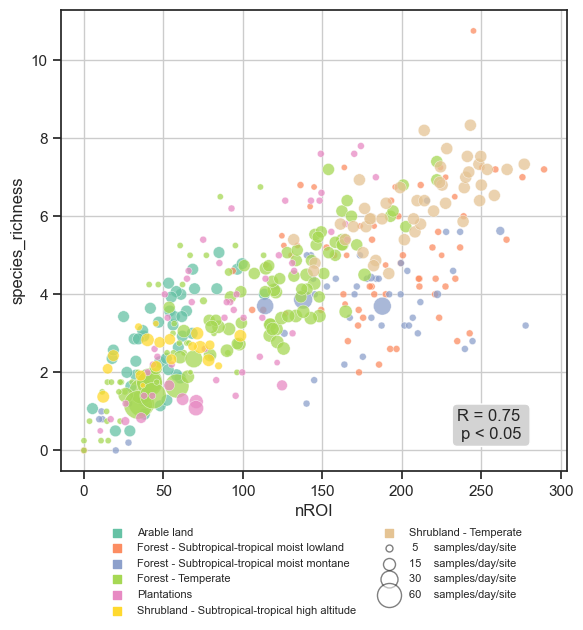

In [92]:
"""===============================================================================
        Display correlation  between the indice and the ground truth
        ------------------------------------------------------------

        Summary of the steps:
        ---------------------
        - Using the grouped data by site and day
        - Select the acoustic index (INDICE) => nROI
        - Select the ground truth (GT) => species_richness
        - Display the correlation plot between the selected index and ground truth:
                - Marker size by number of samples per site and day
                - Color points by habitat
                - Display correlation coefficient and p-value
        - Save the correlation plot figure
        
==============================================================================="""

INDICE_TO_DISPLAY = 'nROI' # nROI, aROI, NP, MFC BI, ACTspCount, EAS, ECU

# Display the correlation graphic between the indice and the ground truth
fig, ax1 = plt.subplots(1, 1)

# sort the column habitat to have the same automatic color assignation
df_mean_by_day = df_mean_by_day.sort_values(by='habitat')

# marker size
# extact the column count from df_mean_by_day, and multiply the values (scalar) by 5
marker_size = df_mean_by_day['count'].values*5

# display the scatterplot
sns.set_theme(style="whitegrid")
sns.set_style("ticks")
sns.scatterplot(data=df_mean_by_day, x=INDICE_TO_DISPLAY, y=GT, 
                hue='habitat', s=marker_size, alpha=0.75,
                palette=HABITAT_COLOR,
                ax=ax1, legend=False)

ax1.grid()
ax1.set_ylabel(INDICE_TO_DISPLAY)
ax1.set_ylabel(GT)
ax1.annotate(
        "R = %.2f \np < 0.05" % (corr_matrix[GT][INDICE_TO_DISPLAY]), 
        xy=(0.85, 0.1), 
        xycoords='axes fraction', 
        ha='center', 
        va='center', 
        bbox=dict(
                facecolor='lightgrey', 
                edgecolor='white', 
                boxstyle='round')
        )

# add a legend with fixed marker size for each habitat and its corresponding color
for HABITAT in df_mean_by_day['habitat'].unique():
        ax1.scatter([], [], c=HABITAT_COLOR[HABITAT], label=HABITAT, marker='s', s=40)

# add bubble size legend
bubble_sizes = [5, 15, 30, 60]
bubble_labels = [' 5     samples/day/site', '15    samples/day/site', '30    samples/day/site', '60    samples/day/site']
for size, label in zip(bubble_sizes, bubble_labels):
        ax1.scatter([], [], c='white', edgecolor='black', alpha=0.5, s=size*5, label=label)


# Move the legend to the bottom
ax1.legend(title="habitat", loc="upper left", fontsize=8)
sns.move_legend(ax1, "upper center", bbox_to_anchor=(.5, -0.1), ncol=2, title=None, frameon=False, fontsize=8)

# Set figure size
fig.set_size_inches((6,6.5))
fig.tight_layout()


In [ ]:
"""===============================================================================
    Correlation analysis on a set of indices with bootstrap and permutation tests
    -----------------------------------------------------------------------------

    Summary of the steps:
    ---------------------
    - Using the grouped data by site and day
    - For each acoustic index:
        - Compute bootstrap correlation with ground truth
        - Compute permutation correlation with ground truth
        - Store statistics (r, CI, p-values)
    - Calculate significance threshold using combined null r's from permutation tests
    - Display indices with correlation coefficient higher than the threshold
    
================================================================================"""

if PROCESS :
    # list of stats as dictionnary (indice, r, ci, p_boot, p_perm)
    stat = []
    # list of null r
    combined_null_rs = []
    # Empty dataframe to store the stats
    df_stat = pd.DataFrame()

    for INDICE in tqdm(CONFIG['list_indices']) : 
            
        x = df_mean_by_day[INDICE].astype('float')
        y = df_mean_by_day[GT]
        
        real_r, p_boot, ci, _ = bootstrap_corr(x ,y , corr_method=CONFIG['correlation_method'], n_boot=CONFIG['n_bootstrap'], seed=CONFIG['seed'])
        _, p_perm, null_rs = permutation_corr(x ,y , corr_method=CONFIG['correlation_method'], n_boot=CONFIG['n_bootstrap'], seed=CONFIG['seed'])
        stat.append({'indice':INDICE, 'r': real_r, 'lower_bound_ci': ci[0], 'upper_bound_ci': ci[1], 'p_boot': p_boot, 'p_perm': p_perm})
        combined_null_rs.extend(null_rs)

    """ -------------------------------------------------------------------------------
        Estimation of the r's threshold. Higher r than the threshold correlates 
        significantly with the species richness
    -----------------------------------------------------------------------------------"""

    combined_null_rs = np.asarray(combined_null_rs)
    combined_null_rs = combined_null_rs.flatten()

    # Adapted From Sarab Sethi's code (https://github.com/sarabsethi/sscape-avian-div-generalisability/blob/main/fig_richness_corrs_num_datasets.py)
    sorted_null_rs = np.sort(np.abs(combined_null_rs))
    sig_mult_hyp_corr = 1 - (0.05/CONFIG['n_bootstrap'])
    sig_ix = int(sig_mult_hyp_corr*len(sorted_null_rs))
    sig_level = sorted_null_rs[sig_ix]

    print('significant results for ({}\'s |r|>={})'.format(CONFIG['correlation_method'], sig_level))

    """ -------------------------------------------------------------------------------
        Dataframe with the statistics    
    -----------------------------------------------------------------------------------"""
    df_stat = pd.DataFrame(stat)
    df_stat['r_threshold'] = sig_level

    """ -------------------------------------------------------------------------------
        Display the indices with a correlation coefficient higher than the threshold
    -----------------------------------------------------------------------------------"""
    # sort the dataframe by r
    df_stat = df_stat.sort_values(by='r', ascending=False)
    # print the dataframe with indices that have a correlation coefficient higher than the threshold
    display(df_stat[df_stat['r'] > df_stat['r_threshold']])
